# 1. Importing libraries

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# 2. Importing EEG data (train.csv) and extracting 10 second secgments 

In [2]:
train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
print('Train shape', train.shape )
train

Train shape (106800, 15)


eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0       1628180742           0                       0.0          353733   
1       1628180742           1                       6.0          353733   
2       1628180742           2                       8.0          353733   
3       1628180742           3                      18.0          353733   
4       1628180742           4                      24.0          353733   
...            ...         ...                       ...             ...   
106795   351917269           6                      12.0      2147388374   
106796   351917269           7                      14.0      2147388374   
106797   351917269           8                      16.0      2147388374   
106798   351917269           9                      18.0      2147388374   
106799   351917269          10                      20.0      2147388374   

        spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                        0                               0.0   127492639   
1                        1                               6.0  3887563113   
2                        2                               8.0  1142670488   
3                        3                              18.0  2718991173   
4                        4                              24.0  3080632009   
...                    ...                               ...         ...   
106795                   6                              12.0  4195677307   
106796                   7                              14.0   290896675   
106797                   8                              16.0   461435451   
106798                   9                              18.0  3786213131   
106799                  10                              20.0  3642716176   

        patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
0            42516          Seizure             3         0         0   
1            42516          Seizure             3         0         0   
2            42516          Seizure             3         0         0   
3            42516          Seizure             3         0         0   
4            42516          Seizure             3         0         0   
...            ...              ...           ...       ...       ...   
106795       10351             LRDA             0         0         0   
106796       10351             LRDA             0         0         0   
106797       10351             LRDA             0         0         0   
106798       10351             LRDA             0         0         0   
106799       10351             LRDA             0         0         0   

        lrda_vote  grda_vote  other_vote  
0               0          0           0  
1               0          0           0  
2               0          0           0  
3               0          0           0  
4               0          0           0  
...           ...        ...         ...  
106795          3          0           0  
106796          3          0           0  
106797          3          0           0  
106798          3          0           0  
106799          3          0           0  

[106800 rows x 15 columns]

In [3]:
ids = train.eeg_id.unique()

In [4]:
import random
n = 10
sample_ids = random.sample(list(ids), n)
sample_ids

[2017057222,
 80729632,
 1677905311,
 3346800758,
 1270784515,
 3373742507,
 1168652626,
 300733838,
 3485729921,
 2292771685]

In [5]:
# CREATING DATA LOADER FOR SPECIFIC EEG IDS

import pandas as pd

def create_data_loader(eeg_ids, eeg_data_dir, train_data, segment_length=10):
    """
    Create a data loader function to extract 10-second EEG segments for specified EEG IDs.
    
    Args:
    - eeg_ids (list): List of EEG IDs for which segments need to be extracted.
    - eeg_data_dir (str): Directory path where EEG data files are stored.
    - train_data (DataFrame): DataFrame containing training data with EEG labels and offsets.
    - segment_length (int): Length of EEG segments in seconds.
    
    Returns:
    - data_loader (generator): Generator function to yield EEG segments along with target labels.
    """
    def data_loader():
        for eeg_id in eeg_ids:
            # Load EEG data for the current EEG ID
            eeg_data_path = f"{eeg_data_dir}/{eeg_id}.parquet"
            example = pd.read_parquet(eeg_data_path)
            
            # Filter training data for the current EEG ID
            train_eegid = train_data[train_data['eeg_id'] == eeg_id]
            offset_values_list = train_eegid['eeg_label_offset_seconds'].tolist()
            print("Number of offset subsamples for EEG ID", eeg_id, ":", len(offset_values_list))
            
            # Extract 10-second EEG segments along with target labels
            for offset in offset_values_list:
                start_index = int(offset) * 200
                end_index = start_index + (segment_length * 200)
                
                # Extract 10-second segment centered around the offset
                middle_index = (start_index + end_index) // 2
                segment_start = middle_index - (segment_length // 2 * 200)
                segment_end = middle_index + (segment_length // 2 * 200)
                
                # Extract EEG segment
                eeg_segment = example.iloc[segment_start:segment_end].reset_index(drop=True)
                
                # Get target labels
                target_labels = train_eegid.iloc[0][['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
                
                # Yield EEG segment along with target labels
                yield eeg_segment, target_labels
    
    return data_loader

# Example usage:
eeg_ids = sample_ids
eeg_data_dir = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs"
train_data = train  # Assuming 'train' is your DataFrame containing training data
segment_length = 10  # 10-second EEG segments
loader = create_data_loader(eeg_ids, eeg_data_dir, train_data, segment_length)

In [6]:
# Getting EEG data and target data from data loader

# Collect all EEG segments and target labels into separate lists
all_segments = []
all_targets = []

# Iterate through the data loader to extract EEG segments and target labels
for eeg_segment, target_labels in loader():
    # Append each EEG segment to the list
    all_segments.append(eeg_segment)
    # Append corresponding target labels to the list
    all_targets.append(target_labels)
    
# Concatenate all segments into a single DataFrame
full_eeg_segments = pd.concat(all_segments, ignore_index=True)
full_eeg_segments

Number of offset subsamples for EEG ID 2017057222 : 4
Number of offset subsamples for EEG ID 80729632 : 1
Number of offset subsamples for EEG ID 1677905311 : 3
Number of offset subsamples for EEG ID 3346800758 : 13
Number of offset subsamples for EEG ID 1270784515 : 1
Number of offset subsamples for EEG ID 3373742507 : 4
Number of offset subsamples for EEG ID 1168652626 : 1
Number of offset subsamples for EEG ID 300733838 : 12
Number of offset subsamples for EEG ID 3485729921 : 4
Number of offset subsamples for EEG ID 2292771685 : 1


Fp1          F3          C3          P3          F7          T3  \
0     -234.199997 -176.520004 -127.070000 -146.479996 -192.199997 -156.580002   
1      -77.889999  -16.750000   36.950001    9.840000  -28.709999   13.290000   
2       27.910000   80.809998  118.300003   84.540001   59.810001   91.180000   
3     -168.279999 -110.589996  -81.349998 -115.110001 -135.050003 -115.110001   
4     -133.979996  -73.639999  -33.230000  -66.730003  -90.919998  -60.349998   
...           ...         ...         ...         ...         ...         ...   
87995  -43.610001  -28.450001  -23.299999  -51.150002  -51.570000  -45.150002   
87996  -20.010000  -38.610001  -35.270000  -62.020000  -44.540001  -53.160000   
87997  -16.170000  -51.020000  -36.770000  -62.880001  -47.689999  -53.230000   
87998  -26.969999  -54.310001  -49.299999  -73.040001  -52.240002  -62.189999   
87999  -23.889999  -46.529999  -54.650002  -80.010002  -63.950001  -75.580002   

               T5          O1          Fz          Cz          Pz         Fp2  \
0     -119.360001 -162.429993 -131.589996 -188.750000  -79.489998 -188.750000   
1       43.330002    9.300000   25.250000  -31.370001  797.780029  -41.200001   
2      117.230003   74.169998  122.820000   53.430000 -488.880005   60.610001   
3      -87.989998 -134.779999  -67.519997 -136.910004 -587.239990 -140.100006   
4      -32.959999  -67.790001  -30.570000  -88.260002  784.489990 -106.070000   
...           ...         ...         ...         ...         ...         ...   
87995  -52.900002  -42.000000  -25.790001  -25.360001  -46.529999  -43.990002   
87996  -61.950001  -51.889999  -26.049999  -33.860001  -56.790001  -71.320000   
87997  -66.470001  -53.709999  -34.209999  -37.430000  -57.630001  -62.790001   
87998  -76.550003  -63.209999  -49.250000  -48.740002  -67.419998  -67.430000   
87999  -87.769997  -70.709999  -51.910000  -54.910000  -73.250000  -58.259998   

               F4          C4          P4          F8          T4          T6  \
0     -180.500000 -122.820000  -95.699997 -125.480003 -166.949997 -153.389999   
1      -19.139999   35.619999   64.070000   17.549999   -2.130000    8.240000   
2       68.589996  117.230003  139.830002  105.010002   75.760002   81.080002   
3     -127.599998  -81.080002  -60.880001  -84.010002 -126.010002 -117.230003   
4      -86.660004  -46.259998  -15.150000  -50.509998  -79.489998  -69.919998   
...           ...         ...         ...         ...         ...         ...   
87995  -25.230000   -9.460000  -36.910000  -12.590000   -0.570000  -28.940001   
87996    3.410000  -17.719999  -47.730000  -19.430000   -6.920000  -40.290001   
87997  -27.969999  -23.080000  -48.820000  -27.469999    2.830000  -43.169998   
87998  -28.620001  -33.779999  -60.169998  -33.290001  -26.459999  -56.750000   
87999   -5.360000  -42.029999  -66.160004  -42.150002  -36.099998  -62.270000   

               O2         EKG  
0     -199.380005   28.709999  
1      -27.120001   30.299999  
2       36.689999   31.100000  
3     -168.809998   24.990000  
4     -107.129997   19.139999  
...           ...         ...  
87995  -50.099998  132.750000  
87996  -61.470001  -44.529999  
87997  -61.900002   31.160000  
87998  -74.080002  153.000000  
87999  -79.180000  -24.129999  

[88000 rows x 20 columns]

In [48]:
all_targets1 = np.array(all_targets)
all_targets1

array([[6, 6, 0, 3, 0, 1],
       [6, 6, 0, 3, 0, 1],
       [6, 6, 0, 3, 0, 1],
       [6, 6, 0, 3, 0, 1],
       [0, 1, 0, 0, 0, 0],
       [0, 3, 0, 1, 0, 9],
       [0, 3, 0, 1, 0, 9],
       [0, 3, 0, 1, 0, 9],
       [0, 0, 0, 1, 2, 2],
       [0, 0, 0, 1, 2, 2],
       [0, 0, 0, 1, 2, 2],
       [0, 0, 0, 1, 2, 2],
       [0, 0, 0, 1, 2, 2],
       [0, 0, 0, 1, 2, 2],
       [0, 0, 0, 1, 2, 2],
       [0, 0, 0, 1, 2, 2],
       [0, 0, 0, 1, 2, 2],
       [0, 0, 0, 1, 2, 2],
       [0, 0, 0, 1, 2, 2],
       [0, 0, 0, 1, 2, 2],
       [0, 0, 0, 1, 2, 2],
       [0, 0, 0, 0, 0, 2],
       [3, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 3, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0],
 

In [7]:
full_eeg_targets = pd.DataFrame(all_targets)
full_eeg_targets

seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote
45028             6         6         0          3          0           1
45028             6         6         0          3          0           1
45028             6         6         0          3          0           1
45028             6         6         0          3          0           1
75502             0         1         0          0          0           0
42495             0         3         0          1          0           9
42495             0         3         0          1          0           9
42495             0         3         0          1          0           9
51770             0         0         0          1          2           2
51770             0         0         0          1          2           2
51770             0         0         0          1          2           2
51770             0         0         0          1          2           2
51770             0         0         0          1          2           2
51770             0         0         0          1          2           2
51770             0         0         0          1          2           2
51770             0         0         0          1          2           2
51770             0         0         0          1          2           2
51770             0         0         0          1          2           2
51770             0         0         0          1          2           2
51770             0         0         0          1          2           2
51770             0         0         0          1          2           2
93271             0         0         0          0          0           2
24623             3         0         0          0          0           0
24623             3         0         0          0          0           0
24623             3         0         0          0          0           0
24623             3         0         0          0          0           0
43842             0         0         0          0          1           1
7952              0         3         0          0          0           0
7952              0         3         0          0          0           0
7952              0         3         0          0          0           0
7952              0         3         0          0          0           0
7952              0         3         0          0          0           0
7952              0         3         0          0          0           0
7952              0         3         0          0          0           0
7952              0         3         0          0          0           0
7952              0         3         0          0          0           0
7952              0         3         0          0          0           0
7952              0         3         0          0          0           0
7952              0         3         0          0          0           0
21423             0         0         0          1          2           0
21423             0         0         0          1          2           0
21423             0         0         0          1          2           0
21423             0         0         0          1          2           0
21427             0         2         0          0          0           0

# 3. Visualizing EEG signals

In [8]:
def plot_eeg(df, title):
    fig, axs = plt.subplots(20, 1, figsize=(30, 20), sharex=True)

    for i, ax in enumerate(axs):
        ax.plot(df.iloc[:,i], color="black")
        ax.set_ylabel(df.columns[i], rotation=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
        ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
        
    fig.suptitle(title, fontsize=50, verticalalignment='top')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the layout to not overlap with the figure title
    plt.show()

In [9]:
eeg_example = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/941668605.parquet')
print(f'eeg_id=941668605 has {eeg_example.shape[0]} samples.')
print()
display(eeg_example)

eeg_id=941668605 has 12800 samples.



Fp1         F3         C3         P3         F7         T3  \
0       4.44  -7.670000 -12.740000  -7.930000 -12.120000 -11.130000   
1     -10.44 -21.320000 -23.200001 -16.100000 -25.610001 -23.559999   
2       0.15 -10.890000 -13.480000  -6.450000  -7.330000  -6.860000   
3      14.08   0.310000  -7.320000  -0.750000  -2.800000  -3.170000   
4      -2.67 -15.240000 -19.610001 -12.400000 -19.719999 -19.980000   
...      ...        ...        ...        ...        ...        ...   
12795   2.37   1.800000  25.570000  33.240002   6.670000  18.969999   
12796   2.31   3.060000  26.910000  35.470001  16.990000  24.420000   
12797  21.50  20.879999  38.639999  45.570000  36.040001  41.900002   
12798  17.76  14.730000  29.709999  34.459999  17.889999  24.740000   
12799   9.30   7.640000  22.350000  29.219999  14.880000  27.469999   

              T5         O1         Fz         Cz         Pz        Fp2  \
0      -6.540000 -22.480000 -20.830000   3.050000 -20.410000  46.290001   
1     -15.540000 -29.860001 -36.730000 -11.390000 -23.930000  32.450001   
2      -1.820000 -19.090000 -27.780001   5.410000 -13.820000  46.669998   
3       1.500000 -16.459999 -13.340000   7.920000 -13.190000  56.810001   
4     -11.080000 -27.080000 -30.139999  -9.310000 -21.740000  40.160000   
...          ...        ...        ...        ...        ...        ...   
12795  35.930000  26.879999 -36.730000  18.680000   9.990000 -20.230000   
12796  42.009998  29.290001 -37.880001  22.990000  15.560000 -17.770000   
12797  54.889999  36.689999 -20.690001  39.669998  21.629999  -0.320000   
12798  37.209999  26.740000 -25.389999  22.440001   9.140000 -13.820000   
12799  35.590000  21.049999 -35.770000  16.190001   8.100000 -22.540001   

              F4         C4     P4         F8         T4     T6         O2  \
0      17.910000  34.110001 -14.19   8.020000  -0.090000 -12.61   4.710000   
1       4.380000  20.680000 -19.10   3.310000  -6.200000  -8.54  -6.720000   
2      21.950001  40.689999  -0.50  22.320000  11.470000   4.53  15.950000   
3      27.270000  41.860001  -4.39  24.360001  13.240000  -4.08  14.470000   
4      10.010000  23.790001 -15.17   6.820000  -4.880000  -9.45  -2.480000   
...          ...        ...    ...        ...        ...    ...        ...   
12795 -38.029999  26.450001   5.61 -43.490002 -31.040001  -5.03  34.580002   
12796 -32.490002  31.480000  14.02 -38.570000 -22.660000   8.29  41.459999   
12797 -16.790001  50.020000  25.27 -22.129999 -10.010000  10.52  57.240002   
12798 -29.660000  29.020000   4.57 -38.250000 -28.940001  -7.48  35.090000   
12799 -36.400002  22.459999   3.96 -44.660000 -30.639999  -3.12  29.820000   

                EKG  
0        374.820007  
1      28996.470703  
2      -3175.120117  
3     -13805.009766  
4      17032.070312  
...             ...  
12795  22134.169922  
12796  15606.870117  
12797 -15107.230469  
12798   1900.670044  
12799  11508.740234  

[12800 rows x 20 columns]

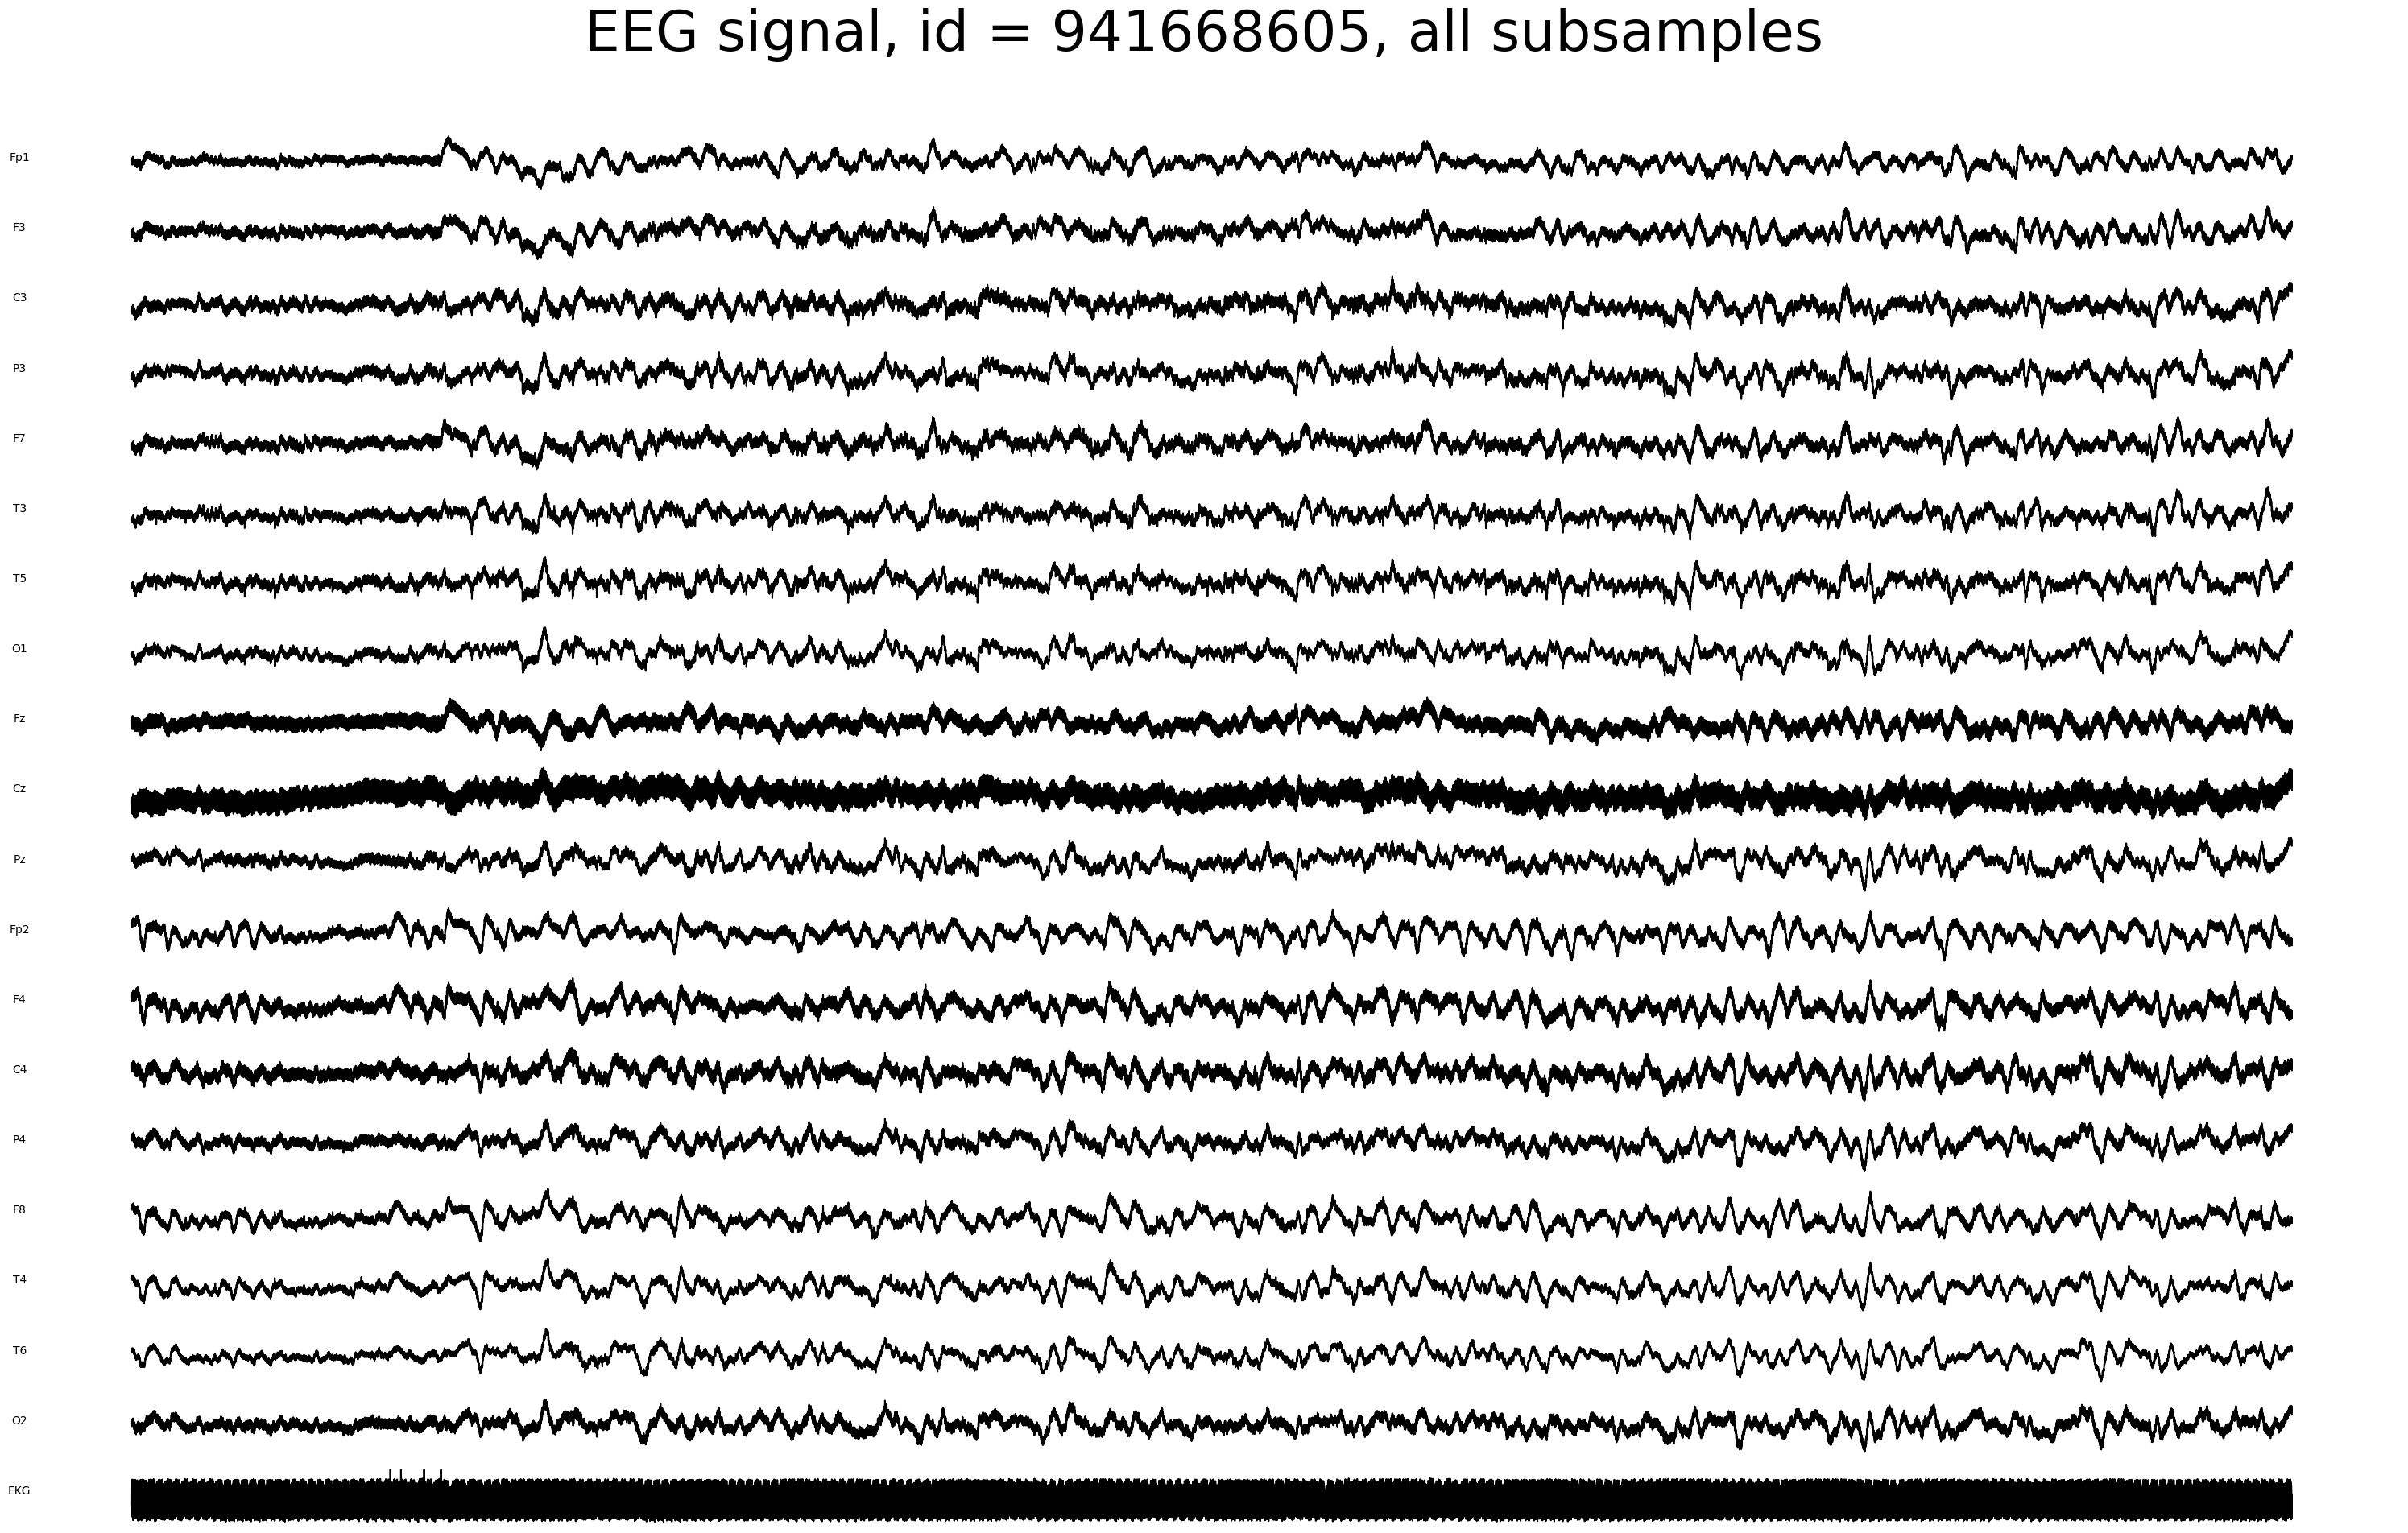

In [10]:
plot_eeg(eeg_example, 'EEG signal, id = 941668605, all subsamples')

In [11]:
offset = 0
start_index = int(offset) * 200
end_index = start_index + (segment_length * 200)

# Extract 10-second segment centered around the offset
middle_index = (start_index + end_index) // 2
segment_start = middle_index - (segment_length // 2 * 200)
segment_end = middle_index + (segment_length // 2 * 200)

# Extract EEG segment
eeg_segment_0 = eeg_example.iloc[segment_start:segment_end].reset_index(drop=True)

# Get target labels
#target_labels = train_eegid.iloc[0][['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]

eeg_segment_0   

Fp1         F3         C3     P3         F7         T3     T5  \
0      4.44  -7.670000 -12.740000  -7.93 -12.120000 -11.130000  -6.54   
1    -10.44 -21.320000 -23.200001 -16.10 -25.610001 -23.559999 -15.54   
2      0.15 -10.890000 -13.480000  -6.45  -7.330000  -6.860000  -1.82   
3     14.08   0.310000  -7.320000  -0.75  -2.800000  -3.170000   1.50   
4     -2.67 -15.240000 -19.610001 -12.40 -19.719999 -19.980000 -11.08   
...     ...        ...        ...    ...        ...        ...    ...   
1995  -4.11 -20.870001  -2.490000   2.89  -8.530000  -2.840000   9.00   
1996  10.57  -6.030000   7.680000  10.72   0.800000   7.100000  15.83   
1997  -4.14 -18.690001  -3.230000  -1.07 -15.070000  -8.920000   3.26   
1998 -14.27 -27.850000  -8.890000  -6.79 -23.260000 -14.730000  -3.34   
1999   1.58 -10.320000   9.170000   7.46  -3.880000   3.910000  11.68   

             O1         Fz         Cz     Pz        Fp2         F4         C4  \
0    -22.480000 -20.830000   3.050000 -20.41  46.290001  17.910000  34.110001   
1    -29.860001 -36.730000 -11.390000 -23.93  32.450001   4.380000  20.680000   
2    -19.090000 -27.780001   5.410000 -13.82  46.669998  21.950001  40.689999   
3    -16.459999 -13.340000   7.920000 -13.19  56.810001  27.270000  41.860001   
4    -27.080000 -30.139999  -9.310000 -21.74  40.160000  10.010000  23.790001   
...         ...        ...        ...    ...        ...        ...        ...   
1995   1.880000 -32.750000  15.470000   2.75  35.590000  16.090000  53.000000   
1996   8.100000 -16.420000  26.830000   6.69  51.119999  27.799999  63.330002   
1997  -2.870000 -30.340000  11.120000  -2.71  33.169998   9.970000  45.930000   
1998 -10.160000 -38.709999   6.340000  -6.71  22.860001   5.090000  40.509998   
1999   1.640000 -19.629999  27.540001   3.46  40.990002  24.370001  57.900002   

             P4         F8         T4         T6         O2           EKG  
0    -14.190000   8.020000  -0.090000 -12.610000   4.710000    374.820007  
1    -19.100000   3.310000  -6.200000  -8.540000  -6.720000  28996.470703  
2     -0.500000  22.320000  11.470000   4.530000  15.950000  -3175.120117  
3     -4.390000  24.360001  13.240000  -4.080000  14.470000 -13805.009766  
4    -15.170000   6.820000  -4.880000  -9.450000  -2.480000  17032.070312  
...         ...        ...        ...        ...        ...           ...  
1995  22.820000   7.410000  18.940001  38.040001  44.500000  17555.210938  
1996  25.309999  15.900000  24.350000  36.049999  51.110001 -17341.589844  
1997   9.500000  -3.520000  10.080000  23.690001  32.430000  12668.790039  
1998   8.610000 -11.620000   3.100000  25.670000  28.680000  24673.189453  
1999  21.290001   9.220000  14.330000  29.320000  45.549999 -12901.700195  

[2000 rows x 20 columns]

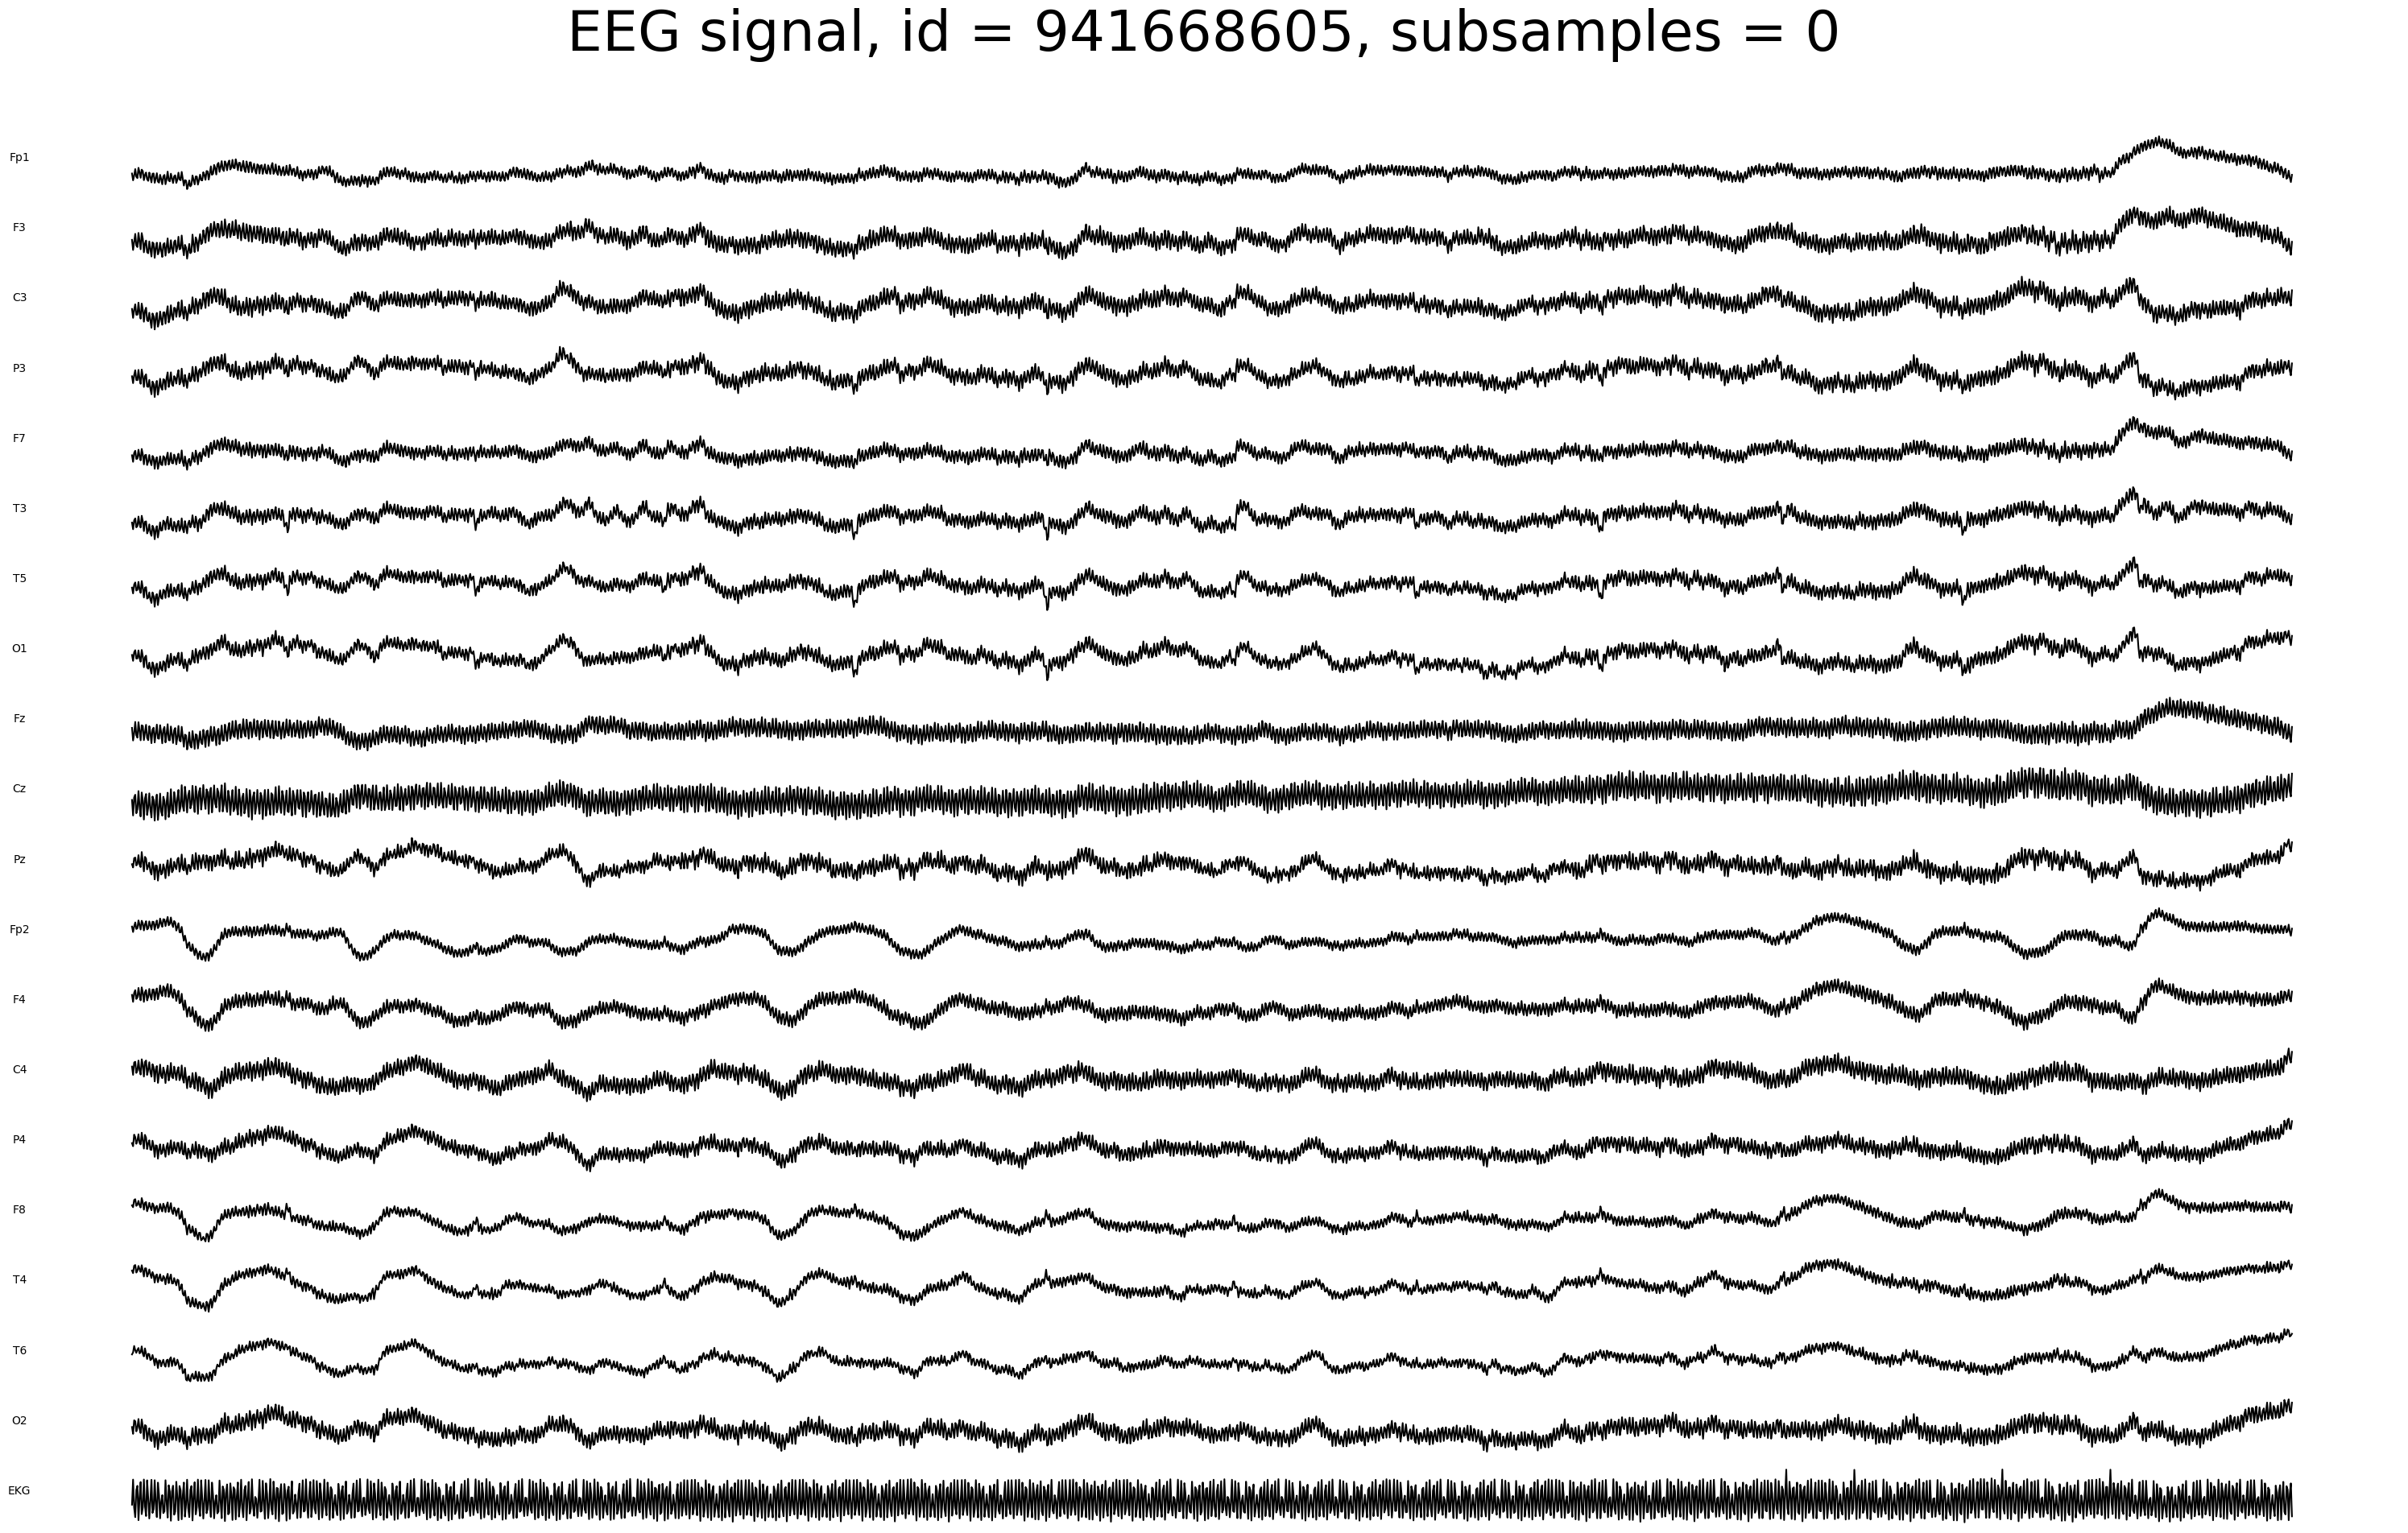

In [12]:
plot_eeg(eeg_segment_0, 'EEG signal, id = 941668605, subsamples = 0')

Text(0.5, 1.0, 'EEG Signal, Fp1')

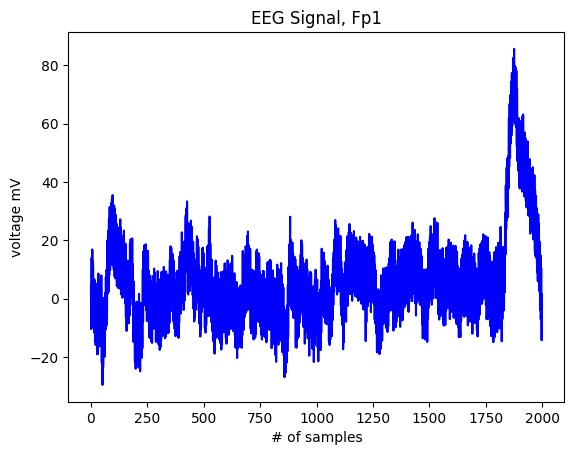

In [13]:
plt.plot(range(2000), eeg_segment_0.iloc[:,0], color="blue")
plt.xlabel("# of samples")
plt.ylabel("voltage mV")
plt.title('EEG Signal, Fp1')

In [14]:
full_eeg_segments

Fp1          F3          C3          P3          F7          T3  \
0     -234.199997 -176.520004 -127.070000 -146.479996 -192.199997 -156.580002   
1      -77.889999  -16.750000   36.950001    9.840000  -28.709999   13.290000   
2       27.910000   80.809998  118.300003   84.540001   59.810001   91.180000   
3     -168.279999 -110.589996  -81.349998 -115.110001 -135.050003 -115.110001   
4     -133.979996  -73.639999  -33.230000  -66.730003  -90.919998  -60.349998   
...           ...         ...         ...         ...         ...         ...   
87995  -43.610001  -28.450001  -23.299999  -51.150002  -51.570000  -45.150002   
87996  -20.010000  -38.610001  -35.270000  -62.020000  -44.540001  -53.160000   
87997  -16.170000  -51.020000  -36.770000  -62.880001  -47.689999  -53.230000   
87998  -26.969999  -54.310001  -49.299999  -73.040001  -52.240002  -62.189999   
87999  -23.889999  -46.529999  -54.650002  -80.010002  -63.950001  -75.580002   

               T5          O1          Fz          Cz          Pz         Fp2  \
0     -119.360001 -162.429993 -131.589996 -188.750000  -79.489998 -188.750000   
1       43.330002    9.300000   25.250000  -31.370001  797.780029  -41.200001   
2      117.230003   74.169998  122.820000   53.430000 -488.880005   60.610001   
3      -87.989998 -134.779999  -67.519997 -136.910004 -587.239990 -140.100006   
4      -32.959999  -67.790001  -30.570000  -88.260002  784.489990 -106.070000   
...           ...         ...         ...         ...         ...         ...   
87995  -52.900002  -42.000000  -25.790001  -25.360001  -46.529999  -43.990002   
87996  -61.950001  -51.889999  -26.049999  -33.860001  -56.790001  -71.320000   
87997  -66.470001  -53.709999  -34.209999  -37.430000  -57.630001  -62.790001   
87998  -76.550003  -63.209999  -49.250000  -48.740002  -67.419998  -67.430000   
87999  -87.769997  -70.709999  -51.910000  -54.910000  -73.250000  -58.259998   

               F4          C4          P4          F8          T4          T6  \
0     -180.500000 -122.820000  -95.699997 -125.480003 -166.949997 -153.389999   
1      -19.139999   35.619999   64.070000   17.549999   -2.130000    8.240000   
2       68.589996  117.230003  139.830002  105.010002   75.760002   81.080002   
3     -127.599998  -81.080002  -60.880001  -84.010002 -126.010002 -117.230003   
4      -86.660004  -46.259998  -15.150000  -50.509998  -79.489998  -69.919998   
...           ...         ...         ...         ...         ...         ...   
87995  -25.230000   -9.460000  -36.910000  -12.590000   -0.570000  -28.940001   
87996    3.410000  -17.719999  -47.730000  -19.430000   -6.920000  -40.290001   
87997  -27.969999  -23.080000  -48.820000  -27.469999    2.830000  -43.169998   
87998  -28.620001  -33.779999  -60.169998  -33.290001  -26.459999  -56.750000   
87999   -5.360000  -42.029999  -66.160004  -42.150002  -36.099998  -62.270000   

               O2         EKG  
0     -199.380005   28.709999  
1      -27.120001   30.299999  
2       36.689999   31.100000  
3     -168.809998   24.990000  
4     -107.129997   19.139999  
...           ...         ...  
87995  -50.099998  132.750000  
87996  -61.470001  -44.529999  
87997  -61.900002   31.160000  
87998  -74.080002  153.000000  
87999  -79.180000  -24.129999  

[88000 rows x 20 columns]

# 3. Feature Engineering

## 3a. Denoising signals with wavelet transform

In [15]:
# denoising function using wavelet transform
import pywt

def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):
    ret = {key:[] for key in x.columns}
    
    for pos in x.columns:
        coeff = pywt.wavedec(x[pos], wavelet, mode="per")
        sigma = (1/0.6745) * maddest(coeff[-level])

        uthresh = sigma * np.sqrt(2*np.log(len(x)))
        coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

        ret[pos]=pywt.waverec(coeff, wavelet, mode='per')
    
    return pd.DataFrame(ret)

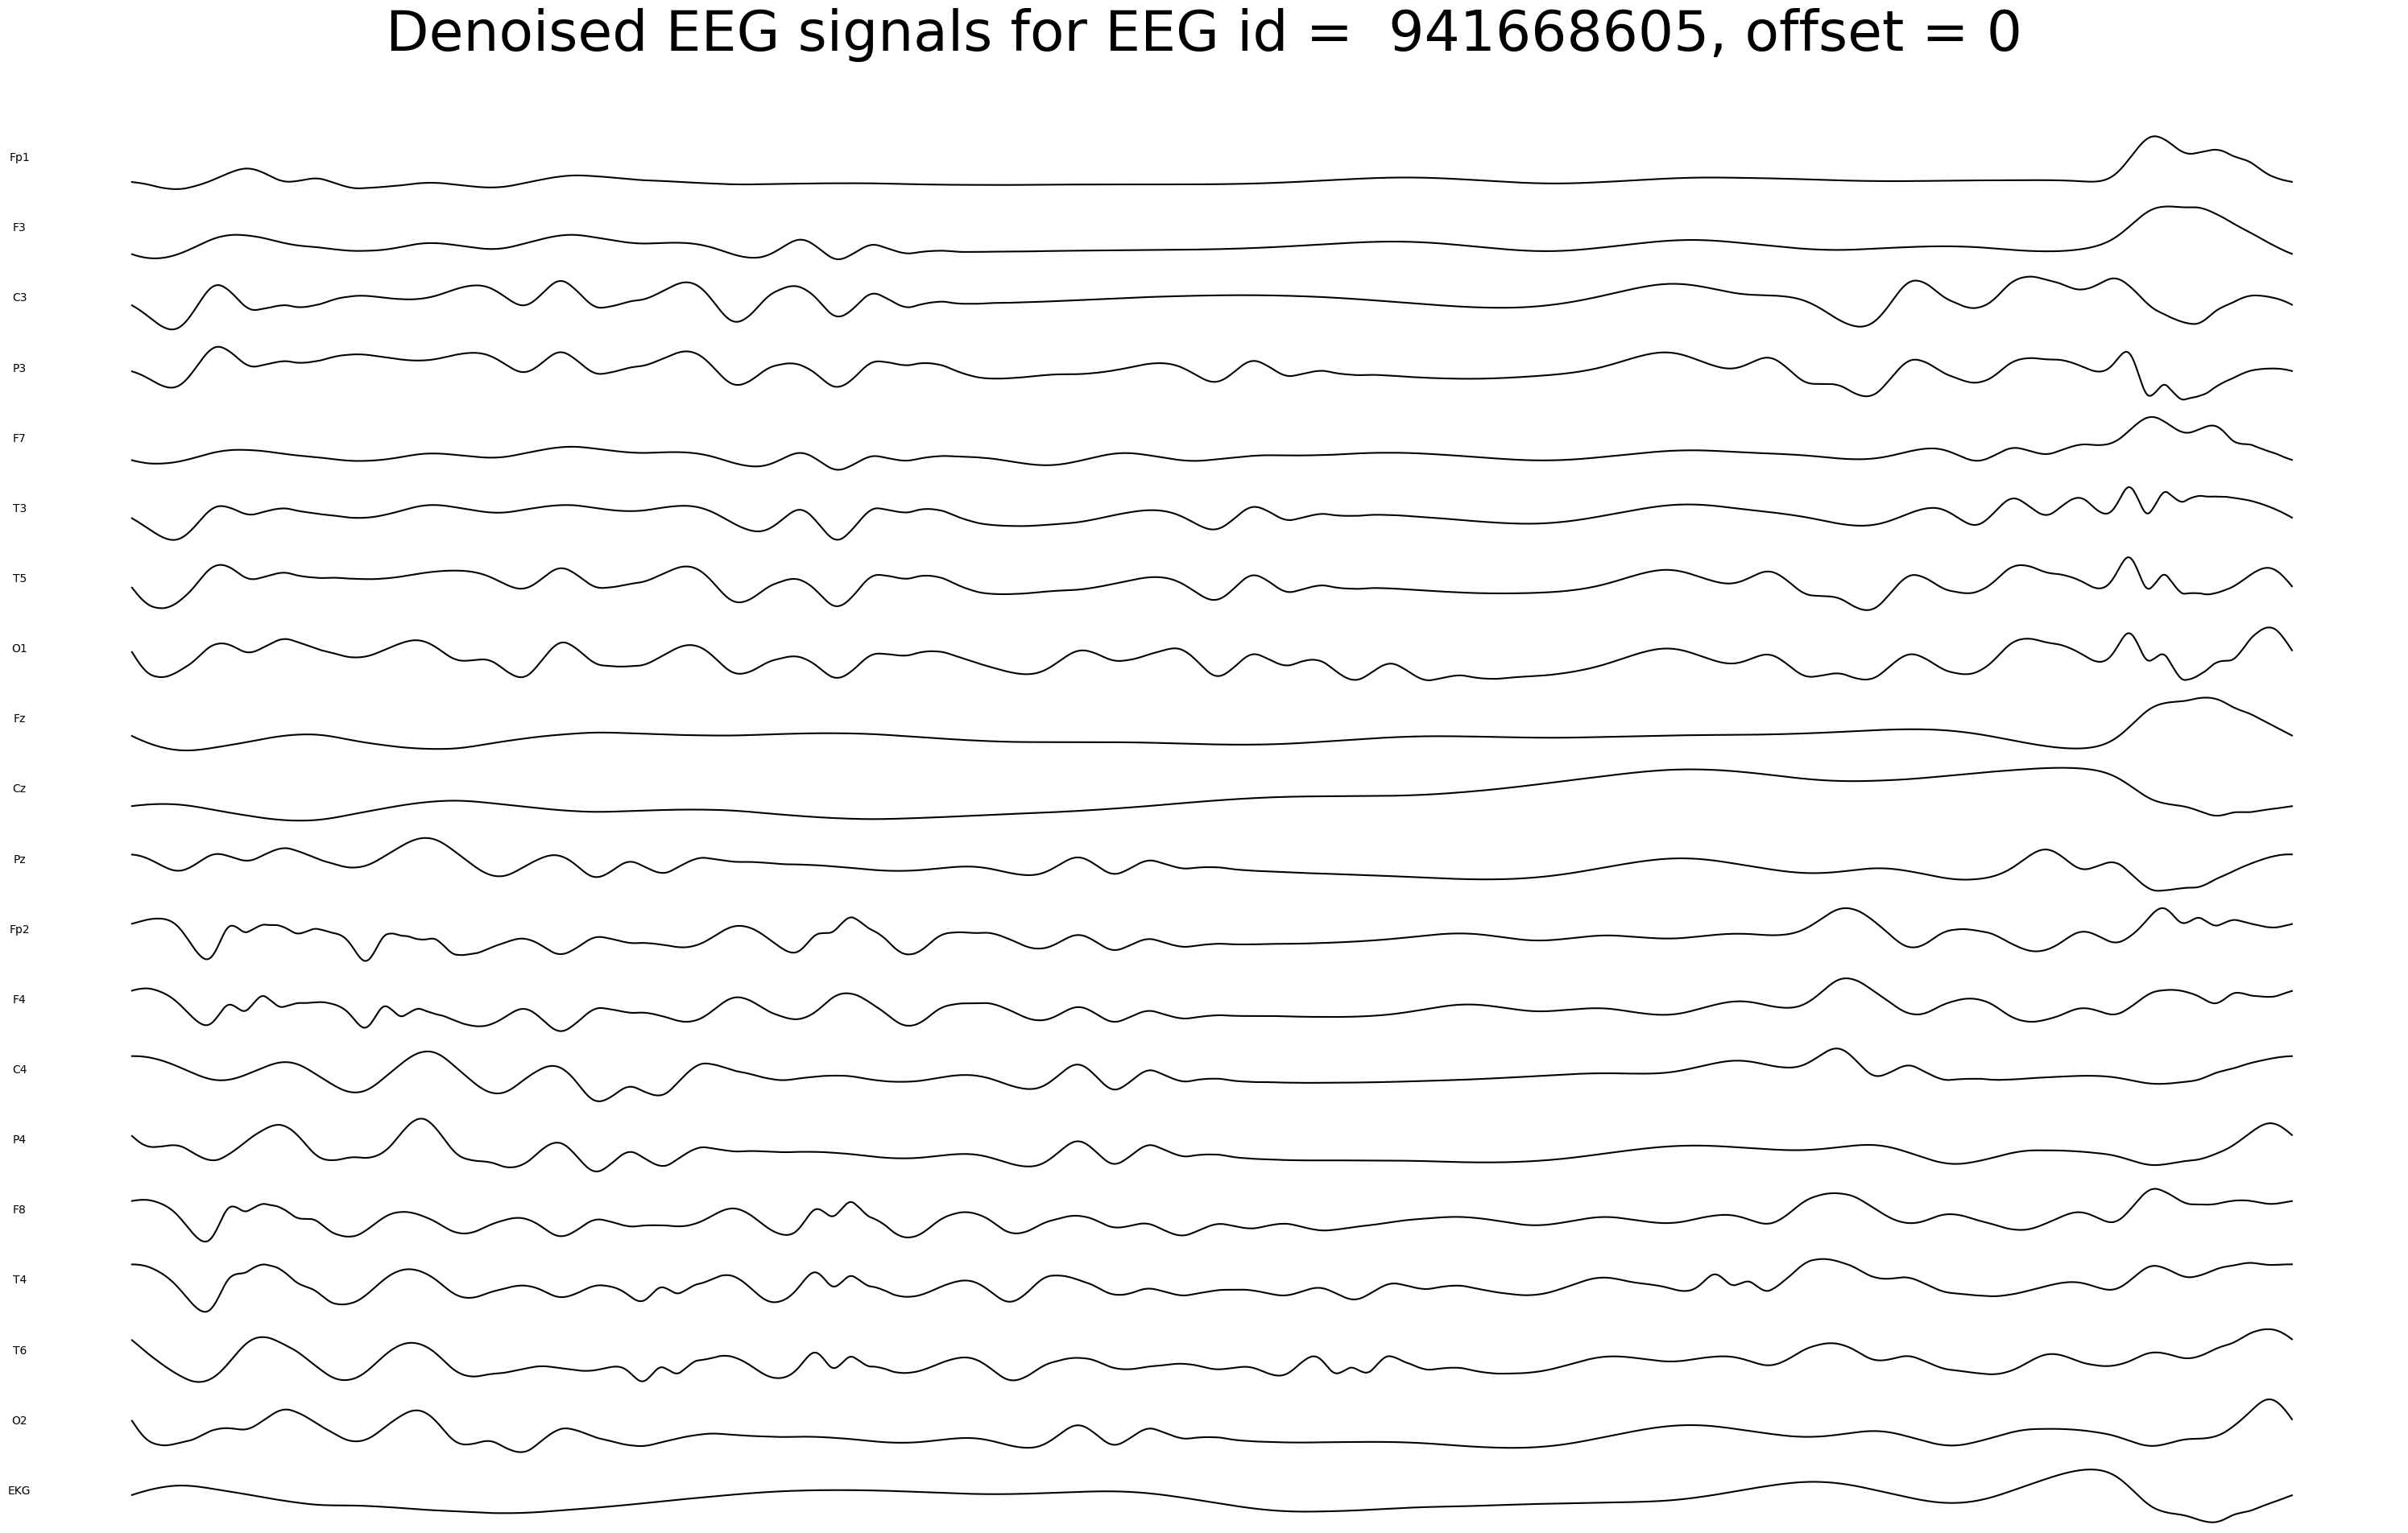

In [16]:
eeg_segment_0_denoised = denoise(eeg_segment_0, wavelet="db8")
plot_eeg(eeg_segment_0_denoised, 'Denoised EEG signals for EEG id =  941668605, offset = 0')

Text(0.5, 1.0, 'EEG Signal, Fp1')

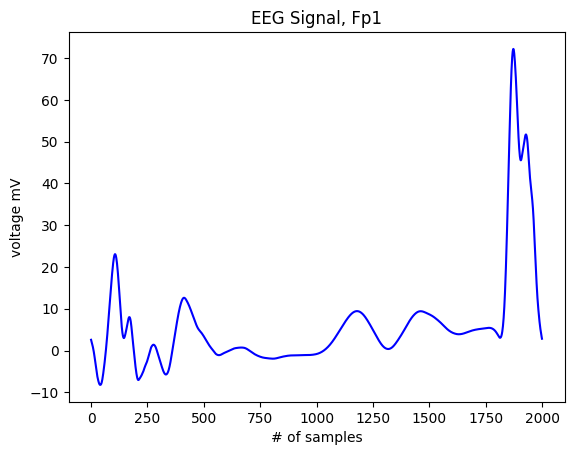

In [17]:
plt.plot(range(2000), eeg_segment_0_denoised.iloc[:,0], color="blue")
plt.xlabel("# of samples")
plt.ylabel("voltage mV")
plt.title('EEG Signal, Fp1')

In [18]:
# Denoise entire data
full_eeg_segments_denoised = denoise(full_eeg_segments, wavelet="db8")
full_eeg_segments_denoised

Fp1         F3         C3         P3         F7         T3  \
0     -56.430336 -41.702774 -82.954865 -27.134926 -50.050098 -34.765797   
1     -57.197243 -37.131226  15.367042 -20.729628 -45.774776 -29.844723   
2     -62.592827 -50.589478  32.995636 -32.673424 -59.660381 -43.950924   
3     -69.272461 -72.697708 -54.482841 -53.493225 -82.278740 -67.223953   
4     -59.983192 -43.825455 -48.551006 -22.666702 -53.578358 -36.793129   
...          ...        ...        ...        ...        ...        ...   
87995 -49.877129 -41.772808 -23.494705 -35.591095 -48.154320 -34.989269   
87996 -51.358360 -42.237469   8.461595 -34.449272 -49.047802 -35.478512   
87997 -52.870506 -42.862514  22.351620 -33.434654 -50.082848 -36.117199   
87998 -54.456696 -44.304329 -14.491479 -33.223015 -51.931034 -37.612034   
87999 -55.885921 -45.398094 -87.862503 -32.629421 -53.416283 -38.730942   

             T5         O1         Fz          Cz          Pz        Fp2  \
0     -2.167317 -32.046326 -68.119301 -103.550980   -1.554161 -45.058208   
1     -2.032968 -32.083736  36.349926   -9.163549  407.537231 -40.374714   
2     -1.899350 -32.120781  57.754852    6.340007  -30.698097 -54.245621   
3     -1.766429 -32.157372 -30.079834  -80.801102 -906.927612 -76.981613   
4     -1.634235 -32.193451 -23.939766  -76.316818  694.968262 -47.101620   
...         ...        ...        ...         ...         ...        ...   
87995 -2.850418 -31.855726 -16.388575  -37.174164  -28.354151 -44.821358   
87996 -2.712401 -31.894241  19.102016   -7.598713    0.897749 -45.403442   
87997 -2.575014 -31.932535  35.734764    4.317842   36.616673 -46.130417   
87998 -2.438340 -31.970652  -0.573197  -33.338223  -50.521317 -47.675423   
87999 -2.302439 -32.008606 -75.066742 -106.684204 -197.805817 -48.837284   

              F4         C4         P4         F8         T4         T6  \
0     -22.487408 -58.540943   3.231946  -0.661535 -22.591564 -33.565079   
1     -15.656956  43.652718  12.177431   6.392501 -17.881382 -26.934496   
2     -27.629202  63.518929   2.373479  -4.203578 -32.178059 -38.995636   
3     -48.662086 -24.386049 -16.547005 -23.299927 -55.631615 -60.113411   
4     -16.684416 -18.150148  17.064594   7.311821 -25.473225 -28.716673   
...          ...        ...        ...        ...        ...        ...   
87995 -32.711723  -4.067507 -17.758085 -13.998257 -22.080355 -43.032669   
87996 -31.229288  30.154091 -14.117352 -11.806455 -22.677601 -41.659218   
87997 -29.876276  45.805790 -10.597292  -9.755998 -23.442211 -40.430267   
87998 -29.340460   9.319200  -7.896591  -8.496320 -25.079439 -40.039078   
87999 -28.413099 -64.751732  -4.818765  -6.903040 -26.363401 -39.285583   

              O2        EKG  
0     -53.353603  14.751618  
1     -53.442776  14.758068  
2     -53.531578  14.764524  
3     -53.619911  14.770981  
4     -53.707657  14.777441  
...          ...        ...  
87995 -52.904827  14.719497  
87996 -52.994823  14.725900  
87997 -53.084686  14.732312  
87998 -53.174442  14.738736  
87999 -53.264126  14.745173  

[88000 rows x 20 columns]

## 3b. Discrete wavelet transform features

In [19]:
from pywt import wavedec

def wavelet_decompose_channels(data, level, output=False):
  # take every x number of points using numpy's slicing (start:stop:step)
    data = data[0::2]

    data.columns.name='channel'

    # transpose the data
    data_t = data.transpose()

    # get the wavelet coefficients at each level in a list
    coeffs_list = wavedec(data_t.values, wavelet='db4', level=level)
    #print(len(coeffs_list))

    # make a list of the component names (later column rows)
    nums = list(range(1,level+1))
    names=[]
    for num in nums:
        names.append('D' + str(num))
    names.append('A' + str(nums[-1]))

  # reverse the names so it counts down
    names = names[::-1]  
    #print(names)

    i = 0
    wavelets = pd.DataFrame()
    for i in range(1, len(coeffs_list)):
    #for i, array in enumerate(coeffs_list):
        #print(i)
        array = coeffs_list[i]
        # turn into a dataframe and transpose
        level_df = pd.DataFrame(array)
        level_df.index = data.columns
        level_df['level'] = names[i]
        level_df= level_df.set_index('level', append=True)
        level_df=level_df.T
        # add the next levels df to another column
        wavelets = pd.concat([wavelets,level_df], axis=1, sort=True)

    # sort values along the channels
    wavelets = wavelets.sort_values(['channel', 'level'], axis=1)

  # remove the AN levels
  #regex = re.compile('D')
  #bad_items = [x for x in list(wavelets.columns.levels[1]) if not regex.match(x)]
  #decom_wavelets = wavelets.drop(bad_items, axis=1, level = 'level')

  #decom_wavelets.index.name='sample'

  #if output:
  #  display(decom_wavelets.head())

    wavelets_cleaned = wavelets.dropna()

    return wavelets_cleaned

dwt_wavelets = wavelet_decompose_channels(full_eeg_segments_denoised, level=5, output=True)

In [20]:
dwt_wavelets

channel          C3                                                      C4  \
level            D1         D2         D3         D4         D5          D1   
0        -26.408861 -18.067221  28.047882  -3.225916  -4.573237  -27.023018   
1        -64.341164 -49.460381  93.231094 -12.101925 -13.928886  -66.216080   
2        100.065254  81.983864  12.682574  -6.522015  12.498033   99.143234   
3         49.237103  33.276138  -5.236176  -4.710965 -48.964939   48.866985   
4        -43.777439 -72.905991  -9.288374   5.602973   5.870589  -45.913715   
...             ...        ...        ...        ...        ...         ...   
1376     -98.170326   0.007416  -4.779143   6.885189  19.451958  -93.479530   
1377     -38.164207  -0.014565  25.916138 -21.257526 -95.165993  -39.129410   
1378      40.548496   0.000470 -26.622761  15.866659  27.206381   40.274330   
1379     125.554260   0.017045   3.443514 -15.155536  85.337578  123.261337   
1380     -30.606028   0.007431  18.540674  22.789824 -31.648417  -33.148079   

channel                                               ...            T5  \
level           D2          D3         D4         D5  ...            D1   
0       -19.857750   31.725218  -3.435058  -5.363193  ...  6.427141e-03   
1       -54.742432  104.689270 -13.426088 -17.650000  ...  1.110797e-02   
2        84.615013   11.243382 -23.370262  -6.597319  ... -1.751447e-02   
3        37.081551   26.367090  -4.175767 -53.837837  ... -3.127940e-05   
4       -23.702290  -17.449848   6.484054 -14.708710  ...  4.779361e-05   
...            ...         ...        ...        ...  ...           ...   
1376     -0.009778   -0.539114   6.545976  16.636562  ... -2.279878e-06   
1377      0.010187    4.029416  -5.718371 -93.296364  ... -2.980232e-08   
1378     -0.000501    5.352914  -8.316858  31.274836  ... -1.594424e-06   
1379     -0.003321  -23.267204 -16.061703  71.515755  ...  2.682209e-06   
1380      0.007882   32.904297  41.077972  -1.361818  ...  1.326203e-06   

channel                                                   T6             \
level            D2        D3        D4        D5         D1         D2   
0         -0.113861  0.435831 -0.019583 -0.036282  -0.357012   2.727354   
1         -0.305423  1.376081 -0.150555 -0.205330   6.205658  17.377195   
2          0.266883 -0.654928 -1.200169 -1.775641  99.888573  80.789513   
3         -0.087653  0.316614  1.291248  3.834907  49.059696  33.208561   
4         -0.003148 -0.148542 -0.378878 -2.010722 -43.469200 -73.393562   
...             ...       ...       ...       ...        ...        ...   
1376      -0.252402  0.918664  0.048787  0.028534 -74.604385  -0.002838   
1377      44.299950 -0.015007 -0.008748  2.029736  12.821836   0.002578   
1378     145.416153  0.663796  0.017729 -1.433722  21.585663  -0.001321   
1379       1.354720 -0.678664 -0.009539 -2.897163  62.504303   0.000459   
1380     -20.774900 -1.558676 -0.047695  0.926318 -22.820032   0.003281   

channel                                   
level           D3         D4         D5  
0        21.646841  -4.987152  -2.807307  
1        71.557793 -16.924189  -7.885332  
2        10.145585   1.426543  16.882008  
3        -2.697882  -2.812949 -46.134495  
4       -10.040325   6.893093  -4.507297  
...            ...        ...        ...  
1376      0.791707  -0.005020  18.271626  
1377      0.004974   0.004751 -79.336113  
1378      0.575272   0.024664  23.086912  
1379     -0.654643  -0.024199  66.476677  
1380     -1.430737  -0.032414  -8.929220  

[1381 rows x 100 columns]

In [21]:
(2.271420+2.706324+6.289705+1.120190+0.239806)/5

2.525489

## c. Finding statistics for DWT features

### Mean Absolute Value

In [22]:
def MAV(data):
    # Initialize an empty DataFrame to store the means for each channel
    means = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        means[channel] = data[channel].abs().mean(axis=1)
    
    means.columns = [f"{col}_DT_MAV" for col in means.columns]
    
    return means


# Use the function with your data
example_wavelet_mean = MAV(dwt_wavelets)
example_wavelet_mean

C3_DT_MAV  C4_DT_MAV  Cz_DT_MAV  EKG_DT_MAV  F3_DT_MAV  F4_DT_MAV  \
0     16.064623  17.480846  14.382673    0.005974   5.335109   6.456679   
1     46.612690  51.344776  41.157158    0.019989  19.688257  24.009228   
2     42.750347  44.993843  43.918564    0.038180  46.815414  42.206005   
3     28.285065  34.065845  20.359398    0.049323  34.753025  29.460632   
4     27.489071  21.651724  26.001883    0.014952  19.983843  26.903091   
...         ...        ...        ...         ...        ...        ...   
1376  25.858807  23.442194  23.313837  152.726837  28.832663  33.243164   
1377  36.103687  28.436749  16.284924  462.504395  21.647032  31.092640   
1378  22.048954  17.043888  12.182593  836.834290  14.900678  19.903370   
1379  45.901588  46.821861  39.032246  280.761078  23.425518  29.968067   
1380  20.718473  21.700008  17.341215  336.965179  14.215314  27.927164   

      F7_DT_MAV  F8_DT_MAV  Fp1_DT_MAV  Fp2_DT_MAV  Fz_DT_MAV  O1_DT_MAV  \
0      5.293469   6.301627    3.408906    5.346171  18.205141   0.033204   
1     19.438641  23.554012   10.320360   19.882212  53.783478   0.110688   
2     47.177467  37.886574   31.152821   47.732735  46.192318   0.206611   
3     24.174587  34.852139   41.566833   26.013056  38.472492   0.296908   
4     29.267324  36.844765    6.665955   42.178112  22.939251   0.099535   
...         ...        ...         ...         ...        ...        ...   
1376  24.759209  28.976648   22.835989   27.656307  29.979767  11.700664   
1377  21.188517  20.302088   21.185556   26.319818  41.241146  23.514259   
1378  16.303066  24.006790   17.698687   18.856136  23.976463   8.669180   
1379  23.629818  33.204880   31.887127   37.471603  49.146770  19.276684   
1380  14.408501  12.756853    9.433100   22.755836  23.662853   6.463130   

      O2_DT_MAV  P3_DT_MAV  P4_DT_MAV   Pz_DT_MAV  T3_DT_MAV  T4_DT_MAV  \
0      0.080945   6.351459   7.621809  100.515549   5.844639   5.668094   
1      0.270386  23.434446  28.328888  382.254303  21.393612  20.768682   
2      0.510471  41.414932  41.010471  194.605499  46.901756  48.279491   
3      0.700855  26.343531  32.051838  239.044952  28.077572  25.744801   
4      0.235689  26.146542  32.253738  218.116241  34.928997  37.735199   
...         ...        ...        ...         ...        ...        ...   
1376  45.213577  31.370930  31.187124   11.623794  23.809834  21.463240   
1377  10.763739  23.605991  25.223774  143.346207  13.084831  10.338707   
1378  34.556564  12.807236  16.422348  134.681595   8.084285   5.911475   
1379  29.129511  37.572655  39.585369   70.224068  23.677212  22.703226   
1380   9.661263  27.102673  25.526522  196.764374  18.216160  15.398315   

      T5_DT_MAV  T6_DT_MAV  
0      0.122397   6.505133  
1      0.409699  23.990032  
2      0.783027  41.826443  
3      1.106091  26.782719  
4      0.508267  27.660696  
...         ...        ...  
1376   0.249678  18.735117  
1377   9.270688  18.434050  
1378  29.506281   9.054766  
1379   0.988018  25.932056  
1380   4.661519   6.643137  

[1381 rows x 20 columns]

### Mean Average Power

In [23]:
def MAVP(data):
    # Initialize an empty DataFrame to store the means for each channel
    means_abs = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        means_abs[channel] = (data[channel]**2).mean(axis = 1)
    
    means_abs.columns = [f"{col}_DT_MAVP" for col in means_abs.columns]
    
    return means_abs

example_wavelet_meanabs = MAVP(dwt_wavelets)
example_wavelet_meanabs

C3_DT_MAVP   C4_DT_MAVP   Cz_DT_MAVP   EKG_DT_MAVP   F3_DT_MAVP  \
0      368.371429   434.325348   295.514557  9.789447e-05    55.060860   
1     3123.724365  3766.585938  2404.037354  9.811560e-04   662.900208   
2     3418.798828  3541.038330  3290.233887  2.413500e-03  3329.382080   
3     1195.753906  1474.839355   745.768433  6.330519e-03  1308.151733   
4     1476.775879   646.550903  1382.760620  5.598555e-04   713.918091   
...           ...          ...          ...           ...          ...   
1376  2017.207642  1811.667725  1789.555420  1.159889e+05  2108.810303   
1377  2327.320312  2056.851807   555.684265  1.068154e+06   708.060852   
1378   668.978027   539.592163   353.331818  3.497844e+06   479.975494   
1379  4657.584473  4221.440430  3550.730957  3.919382e+05  1198.231201   
1380   560.296753   774.148438   505.637207  5.624248e+05   353.350586   

       F4_DT_MAVP   F7_DT_MAVP   F8_DT_MAVP  Fp1_DT_MAVP  Fp2_DT_MAVP  \
0      102.431908    53.022804   104.153076    37.409737    56.503792   
1     1169.023193   646.120483  1173.427002   349.691895   685.262634   
2     3462.866699  3302.987549  3035.229004  1028.964722  3471.303467   
3     1385.703491   847.911621  1928.727295  2750.493164  1004.971497   
4     1464.584473  1493.110962  1669.950928   123.029495  2237.603271   
...           ...          ...          ...          ...          ...   
1376  2547.889893  1400.307251  2285.437012  1317.631104  2175.044678   
1377  1805.097412   909.448853   779.219849   867.583130   908.007507   
1378   561.839539   566.741638  1221.665649   462.661926   649.020874   
1379  1548.082642  1102.718506  3262.918213  1936.495850  4112.500977   
1380  1853.233032   326.950684   308.329315   154.282196   988.717163   

       Fz_DT_MAVP   O1_DT_MAVP    O2_DT_MAVP   P3_DT_MAVP   P4_DT_MAVP  \
0      473.082520     0.002959      0.017789    96.323524   169.744232   
1     4149.682617     0.029676      0.178352  1101.771729  1866.664795   
2     3561.827393     0.070815      0.431538  3269.232666  3511.929688   
3     1932.379639     0.239802      1.313283  1081.055298  1780.761353   
4      664.824341     0.021707      0.134721  1451.311279  1607.907959   
...           ...          ...           ...          ...          ...   
1376  2148.375488   645.036011  10080.343750  2492.208984  2478.877930   
1377  3721.909424  2720.111328    543.938538  1495.126343  1517.718018   
1378   841.944214   350.942780   5863.421875   401.106873   514.628662   
1379  5224.636719  1791.222290   4110.760742  3792.293701  3595.195801   
1380   873.303528   179.784271    436.500153  2127.838379  1097.616455   

         Pz_DT_MAVP   T3_DT_MAVP   T4_DT_MAVP   T5_DT_MAVP   T6_DT_MAVP  
0      13889.623047    68.270401    62.459015     0.040931   101.780861  
1     200374.390625   814.805298   752.798279     0.410366  1161.920166  
2      42441.882812  3532.227295  3574.552002     1.018754  3378.928467  
3     117653.390625  1140.483032   989.861206     3.296353  1130.649048  
4     146049.531250  1802.252686  1833.080078     0.841725  1488.964966  
...             ...          ...          ...          ...          ...  
1376     641.907532  1402.123779  1345.631226     0.182169  1180.058838  
1377   99923.125000   267.344238   330.393005   393.321167  1291.723633  
1378   89425.585938   121.059425   104.870522  4229.670898   199.855560  
1379   23628.255859  1064.383057  1290.689087     2.137900  1665.273071  
1380  192610.968750   483.574524   648.193420    86.977264   120.506569  

[1381 rows x 20 columns]

### Standard Deviation (STD)

In [24]:
def std_val(data):
    # Initialize an empty DataFrame to store the means for each channel
    std_vals = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        std_vals[channel] = data[channel].std(axis = 1)
    
    std_vals.columns = [f"{col}_DT_STD" for col in std_vals.columns]
    
    return std_vals

example_wavelet_std = std_val(dwt_wavelets)
example_wavelet_std

C3_DT_STD  C4_DT_STD  Cz_DT_STD   EKG_DT_STD  F3_DT_STD  F4_DT_STD  \
0     20.763334  22.676363  18.296774     0.010647   7.857610  10.726881   
1     61.612267  67.794937  53.531437     0.034092  25.846167  34.890015   
2     47.532299  55.357796  41.252178     0.040683  37.711060  45.846485   
3     38.299370  41.183903  26.817106     0.071265  39.171528  41.055424   
4     34.503292  18.819523  32.216141     0.020504  25.941803  33.197971   
...         ...        ...        ...          ...        ...        ...   
1376  47.202686  44.873463  40.066746   340.805634  39.960732  56.030323   
1377  45.619556  40.888424  20.701694  1033.346680  28.604603  41.088661   
1378  25.957211  20.959414  17.763077  1870.023682  24.450342  25.961210   
1379  61.951683  63.785931  58.059250   625.611450  28.492903  28.522913   
1380  26.047955  29.828695  24.716431   749.069092  20.194176  41.684425   

      F7_DT_STD  F8_DT_STD  Fp1_DT_STD  Fp2_DT_STD  Fz_DT_STD  O1_DT_STD  \
0      7.677642  10.831571    6.381750    7.933593  23.731493   0.058677   
1     25.292789  35.171108   19.712757   26.137453  71.237259   0.187773   
2     36.695950  46.523666    8.548881   38.614918  57.536400   0.222846   
3     28.818092  48.999676   53.690067   31.972775  48.450085   0.443901   
4     38.859322  29.643723   11.666807   47.128990  20.424707   0.121448   
...         ...        ...         ...         ...        ...        ...   
1376  41.349739  43.503605   31.546568   49.779030  49.909492  25.296043   
1377  32.842136  27.317013   32.920334   28.739738  59.525429  52.259518   
1378  26.150326  28.402018   23.633739   27.284784  29.739059  18.895441   
1379  26.090075  54.006138   33.906250   60.432621  63.561497  42.292324   
1380  18.922054  19.583178   13.882711   31.133457  30.881048  13.135395   

       O2_DT_STD  P3_DT_STD  P4_DT_STD   Pz_DT_STD  T3_DT_STD  T4_DT_STD  \
0       0.143681  10.388223  13.846087  128.290207   8.715073   8.333949   
1       0.459969  33.780582  44.750751  498.190369  28.541134  27.352623   
2       0.546827  44.074310  54.512054  210.991913  40.811352  39.427826   
3       1.033937  36.096416  47.098370  376.787598  36.835274  33.479847   
4       0.314585  33.197323  38.648914  407.654694  38.380722  32.776039   
...          ...        ...        ...         ...        ...        ...   
1376  100.421165  55.462219  54.867908   25.486076  36.328922  33.500095   
1377   23.132240  34.270744  35.686565  315.009338  17.661299  19.504896   
1378   76.398994  18.367929  19.618631  299.374878  11.268406   9.410777   
1379   64.000534  54.850449  58.568581  152.875916  33.226959  31.333921   
1380   20.712879  43.288334  34.861713  438.604401  24.260933  27.757648   

      T5_DT_STD  T6_DT_STD  
0      0.217830  10.680226  
1      0.697576  34.714218  
2      0.837711  45.131435  
3      1.639083  36.965160  
4      0.853968  32.954185  
...         ...        ...  
1376   0.447287  36.342667  
1377  19.607128  37.330002  
1378  65.120697  12.138593  
1379   1.556787  35.475536  
1380   9.257744   9.771946  

[1381 rows x 20 columns]

### Variance

In [25]:
def var_val(data):
    # Initialize an empty DataFrame to store the means for each channel
    var = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        var[channel] = data[channel].var(axis = 1)
    
    var.columns = [f"{col}_DT_VAR" for col in var.columns]
    
    return var

example_wavelet_var = var_val(dwt_wavelets)
example_wavelet_var

C3_DT_VAR    C4_DT_VAR    Cz_DT_VAR    EKG_DT_VAR    F3_DT_VAR  \
0      431.116058   514.217407   334.771912  1.133512e-04    61.742035   
1     3796.071533  4596.153320  2865.614746  1.162277e-03   668.024292   
2     2259.319336  3064.485352  1701.742188  1.655075e-03  1422.124146   
3     1466.841675  1696.113770   719.157166  5.078674e-03  1534.408691   
4     1190.477295   354.174469  1037.879761  4.204183e-04   672.977173   
...           ...          ...          ...           ...          ...   
1376  2228.093750  2013.627563  1605.344116  1.161485e+05  1596.860107   
1377  2081.144043  1671.863159   428.560120  1.067805e+06   818.223267   
1378   673.776794   439.297028   315.526917  3.496989e+06   597.819275   
1379  3838.011230  4068.645020  3370.876465  3.913897e+05   811.845459   
1380   678.495972   889.751038   610.901978  5.611045e+05   407.804749   

        F4_DT_VAR    F7_DT_VAR    F8_DT_VAR   Fp1_DT_VAR   Fp2_DT_VAR  \
0      115.065987    58.946190   117.322929    40.726730    62.941902   
1     1217.313110   639.725220  1237.006836   388.592804   683.166443   
2     2101.900146  1346.592651  2164.451416    73.083366  1491.111816   
3     1685.547852   830.482483  2400.968262  2882.623291  1022.258362   
4     1102.105225  1510.046875   878.750305   136.114395  2221.141602   
...           ...          ...          ...          ...          ...   
1376  3139.396973  1709.801025  1892.563477   995.185974  2477.951904   
1377  1688.278198  1078.605957   746.219177  1083.748413   825.972534   
1378   673.984436   683.839539   806.674622   558.553650   744.459412   
1379   813.556580   680.691956  2916.663086  1149.633789  3652.101807   
1380  1737.591309   358.044159   383.500854   192.729675   969.292114   

        Fz_DT_VAR    O1_DT_VAR     O2_DT_VAR    P3_DT_VAR    P4_DT_VAR  \
0      563.183777     0.003443      0.020644   107.915176   191.714142   
1     5074.746582     0.035259      0.211571  1141.127686  2002.629639   
2     3310.437256     0.049660      0.299020  1942.544800  2971.563965   
3     2347.410645     0.197048      1.069027  1302.951416  2218.256592   
4      417.168640     0.014750      0.098964  1102.062256  1493.738647   
...           ...          ...           ...          ...          ...   
1376  2490.957520   639.889832  10084.411133  3076.057861  3010.487305   
1377  3543.276855  2731.057129    535.100525  1174.483887  1273.530884   
1378   884.411621   357.037720   5836.806641   337.380829   384.890686   
1379  4040.063965  1788.640625   4096.068359  3008.571777  3430.278564   
1380   953.639160   172.538605    429.023376  1873.880005  1215.339111   

          Pz_DT_VAR    T3_DT_VAR    T4_DT_VAR    T5_DT_VAR    T6_DT_VAR  
0      16458.378906    75.952492    69.454704     0.047450   114.067238  
1     248193.640625   814.596375   748.165955     0.486613  1205.077026  
2      44517.589844  1665.566406  1554.553345     0.701760  2036.846313  
3     141968.890625  1356.837280  1120.900146     2.686594  1366.423096  
4     166182.359375  1473.079834  1074.268677     0.729261  1085.978394  
...             ...          ...          ...          ...          ...  
1376     649.540100  1319.790649  1122.256470     0.200066  1320.789307  
1377   99230.882812   311.921448   380.441010   384.439453  1393.528931  
1378   89625.320312   126.976967    88.562721  4240.705566   147.345444  
1379   23371.044922  1104.030762   981.814636     2.423586  1258.513550  
1380  192373.812500   588.592834   770.487061    85.705826    95.490936  

[1381 rows x 20 columns]

### Ratio channels

In [26]:
def ratio_channels(epoch_data):
    # Initialize an empty DataFrame to store the ratio values for each pair of channels
    ratio_data = pd.DataFrame(index=epoch_data.index)
    
    # Iterate over each pair of adjacent channels
    for i in range(len(epoch_data.columns) - 1):
        channel1 = epoch_data.columns[i]
        channel2 = epoch_data.columns[i + 1]
        
        # Calculate the ratio between the values of the two channels
        ratio_data[f"{channel1}-{channel2}_Ratio"] = epoch_data[channel1] / epoch_data[channel2]
    
    return ratio_data

# Example usage:
example_ratio_data = ratio_channels(dwt_wavelets)
example_ratio_data


('C3', 'D1')-('C3', 'D2')_Ratio  ('C3', 'D2')-('C3', 'D3')_Ratio  \
0                            1.461700                        -0.644156   
1                            1.300863                        -0.530514   
2                            1.220548                         6.464292   
3                            1.479652                        -6.355045   
4                            0.600464                         7.849166   
...                               ...                              ...   
1376                    -13237.467773                        -0.001552   
1377                      2620.304688                        -0.000562   
1378                     86349.140625                        -0.000018   
1379                      7365.860352                         0.004950   
1380                     -4118.777832                         0.000401   

      ('C3', 'D3')-('C3', 'D4')_Ratio  ('C3', 'D4')-('C3', 'D5')_Ratio  \
0                           -8.694547                         0.705390   
1                           -7.703824                         0.868837   
2                           -1.944579                        -0.521843   
3                            1.111487                         0.096211   
4                           -1.657758                         0.954414   
...                               ...                              ...   
1376                        -0.694119                         0.353959   
1377                        -1.219151                         0.223373   
1378                        -1.677906                         0.583196   
1379                        -0.227212                        -0.177595   
1380                         0.813551                        -0.720094   

      ('C3', 'D5')-('C4', 'D1')_Ratio  ('C4', 'D1')-('C4', 'D2')_Ratio  \
0                            0.169235                         1.360830   
1                            0.210355                         1.209593   
2                            0.126060                         1.171698   
3                           -1.002005                         1.317825   
4                           -0.127861                         1.937100   
...                               ...                              ...   
1376                        -0.208088                      9560.651367   
1377                         2.432084                     -3841.105225   
1378                         0.675527                    -80427.750000   
1379                         0.692330                    -37113.585938   
1380                         0.954759                     -4205.501465   

      ('C4', 'D2')-('C4', 'D3')_Ratio  ('C4', 'D3')-('C4', 'D4')_Ratio  \
0                           -0.625930                        -9.235715   
1                           -0.522904                        -7.797451   
2                            7.525761                        -0.481098   
3                            1.406357                        -6.314310   
4                            1.358309                        -2.691194   
...                               ...                              ...   
1376                         0.018136                        -0.082358   
1377                         0.002528                        -0.704644   
1378                        -0.000094                        -0.643622   
1379                         0.000143                         1.448614   
1380                         0.000240                         0.801020   

      ('C4', 'D4')-('C4', 'D5')_Ratio  ('C4', 'D5')-('Cz', 'D1')_Ratio  ...  \
0                            0.640488                         0.207192  ...   
1                            0.760685                         0.280312  ...   
2                            3.542388                        -0.066934  ...   
3                            0.077562                        -1.101872  ...   
4                           -0.440831                  

### Shanon Entropy

In [27]:
from scipy.stats import entropy

def shannon_entropy(data):
    # Initialize an empty DataFrame to store the entropy values for each channel
    entropy_df = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the entropy across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
        # Calculate the entropy for the current channel
        entropy_values = data[channel].apply(lambda x: entropy(x.abs(), base=2), axis=1)
        entropy_df[channel + '_entropy'] = entropy_values

    return entropy_df

# Example usage:
example_wavelet_entropy = shannon_entropy(dwt_wavelets)
example_wavelet_entropy


C3_entropy  C4_entropy  Cz_entropy  EKG_entropy  F3_entropy  F4_entropy  \
0       1.963494    1.970600    1.964386     1.266141    1.708983    1.441247   
1       1.980504    1.995550    1.982536     1.440870    1.868181    1.724551   
2       1.677770    1.756300    1.789282     1.772769    1.929120    1.577891   
3       1.890475    2.068692    1.730797     1.229365    2.260419    1.760516   
4       1.656142    2.063568    1.584848     1.237207    1.725192    1.556266   
...          ...         ...         ...          ...         ...         ...   
1376    1.114764    0.929394    0.863431     0.027728    1.335037    1.301902   
1377    1.727405    1.244265    1.435156     0.008087    1.826090    1.641902   
1378    1.926533    1.620295    1.450920     0.006476    1.390467    1.904336   
1379    1.357594    1.606364    1.373683     0.028251    1.357951    1.655437   
1380    1.968144    1.655452    1.703127     0.043151    1.599923    1.422453   

      F7_entropy  F8_entropy  Fp1_entropy  Fp2_entropy  Fz_entropy  \
0       1.733537    1.344268     1.032474     1.675231    1.964962   
1       1.856041    1.685306     1.055613     1.849850    1.992473   
2       1.979550    1.469244     2.279719     1.946479    1.811207   
3       1.971022    1.845509     1.877068     1.953697    2.071306   
4       1.790651    2.159029     1.280675     2.110985    2.155669   
...          ...         ...          ...          ...         ...   
1376    1.379297    1.046673     1.366189     1.114709    1.328088   
1377    1.505694    1.485950     1.578074     1.971887    1.505999   
1378    1.507183    1.413813     1.879086     1.571700    1.850585   
1379    1.535832    1.025457     1.591181     1.139837    1.386242   
1380    1.781579    1.592921     1.729230     1.623632    1.828041   

      O1_entropy  O2_entropy  P3_entropy  P4_entropy  Pz_entropy  T3_entropy  \
0       1.293126    1.279144    1.489565    1.175732    1.977699    1.685347   
1       1.455211    1.447842    1.731924    1.579032    1.972285    1.826434   
2       1.778394    1.776114    1.618879    1.441995    2.232853    1.888692   
3       1.175579    1.197576    1.810594    1.685337    1.593784    1.928975   
4       1.336324    1.256645    1.483551    1.941704    1.010079    1.954564   
...          ...         ...         ...         ...         ...         ...   
1376    0.216530    0.067181    1.065645    1.139161    0.189950    1.280879   
1377    0.069232    0.206505    1.034597    1.369520    0.107005    1.793347   
1378    0.245041    0.083529    1.254360    1.652824    0.065522    1.683297   
1379    0.149565    0.130873    1.058522    1.484872    0.159620    1.611035   
1380    0.408271    0.227901    1.074890    1.758415    0.027124    1.879271   

      T4_entropy  T5_entropy  T6_entropy  
0       1.710356    1.269759    1.482105  
1       1.841016    1.445203    1.726209  
2       1.941177    1.770841    1.593215  
3       1.885719    1.187367    1.789800  
4       2.128599    0.928392    1.661220  
...          ...         ...         ...  
1376    0.942110    1.099308    0.780916  
1377    0.843027    0.266193    0.583990  
1378    0.968139    0.122145    1.091322  
1379    1.044660    1.374218    1.042517  
1380    1.056186    0.612107    1.088065  

[1381 rows x 20 columns]

In [28]:
statistics = pd.concat([example_wavelet_mean, example_wavelet_meanabs, example_wavelet_std, example_wavelet_var, example_ratio_data, example_wavelet_entropy], axis=1)

# Concatenate statistics with the original DataFrame
dwt_with_statistics = pd.concat([dwt_wavelets, statistics], axis=1)

In [36]:
dwt_with_statistics

(C3, D1)   (C3, D2)   (C3, D3)   (C3, D4)   (C3, D5)    (C4, D1)  \
0     -26.408861 -18.067221  28.047882  -3.225916  -4.573237  -27.023018   
1     -64.341164 -49.460381  93.231094 -12.101925 -13.928886  -66.216080   
2     100.065254  81.983864  12.682574  -6.522015  12.498033   99.143234   
3      49.237103  33.276138  -5.236176  -4.710965 -48.964939   48.866985   
4     -43.777439 -72.905991  -9.288374   5.602973   5.870589  -45.913715   
...          ...        ...        ...        ...        ...         ...   
1376  -98.170326   0.007416  -4.779143   6.885189  19.451958  -93.479530   
1377  -38.164207  -0.014565  25.916138 -21.257526 -95.165993  -39.129410   
1378   40.548496   0.000470 -26.622761  15.866659  27.206381   40.274330   
1379  125.554260   0.017045   3.443514 -15.155536  85.337578  123.261337   
1380  -30.606028   0.007431  18.540674  22.789824 -31.648417  -33.148079   

       (C4, D2)    (C4, D3)   (C4, D4)   (C4, D5)  ...  Fz_entropy  \
0    -19.857750   31.725218  -3.435058  -5.363193  ...    1.964962   
1    -54.742432  104.689270 -13.426088 -17.650000  ...    1.992473   
2     84.615013   11.243382 -23.370262  -6.597319  ...    1.811207   
3     37.081551   26.367090  -4.175767 -53.837837  ...    2.071306   
4    -23.702290  -17.449848   6.484054 -14.708710  ...    2.155669   
...         ...         ...        ...        ...  ...         ...   
1376  -0.009778   -0.539114   6.545976  16.636562  ...    1.328088   
1377   0.010187    4.029416  -5.718371 -93.296364  ...    1.505999   
1378  -0.000501    5.352914  -8.316858  31.274836  ...    1.850585   
1379  -0.003321  -23.267204 -16.061703  71.515755  ...    1.386242   
1380   0.007882   32.904297  41.077972  -1.361818  ...    1.828041   

      O1_entropy  O2_entropy  P3_entropy  P4_entropy  Pz_entropy  T3_entropy  \
0       1.293126    1.279144    1.489565    1.175732    1.977699    1.685347   
1       1.455211    1.447842    1.731924    1.579032    1.972285    1.826434   
2       1.778394    1.776114    1.618879    1.441995    2.232853    1.888692   
3       1.175579    1.197576    1.810594    1.685337    1.593784    1.928975   
4       1.336324    1.256645    1.483551    1.941704    1.010079    1.954564   
...          ...         ...         ...         ...         ...         ...   
1376    0.216530    0.067181    1.065645    1.139161    0.189950    1.280879   
1377    0.069232    0.206505    1.034597    1.369520    0.107005    1.793347   
1378    0.245041    0.083529    1.254360    1.652824    0.065522    1.683297   
1379    0.149565    0.130873    1.058522    1.484872    0.159620    1.611035   
1380    0.408271    0.227901    1.074890    1.758415    0.027124    1.879271   

      T4_entropy  T5_entropy  T6_entropy  
0       1.710356    1.269759    1.482105  
1       1.841016    1.445203    1.726209  
2       1.941177    1.770841    1.593215  
3       1.885719    1.187367    1.789800  
4       2.128599    0.928392    1.661220  
...          ...         ...         ...  
1376    0.942110    1.099308    0.780916  
1377    0.843027    0.266193    0.583990  
1378    0.968139    0.122145    1.091322  
1379    1.044660    1.374218    1.042517  
1380    1.056186    0.612107    1.088065  

[1381 rows x 299 columns]

## d. Feature Selection and Dimensionality Reduction

### Correlation Matrix

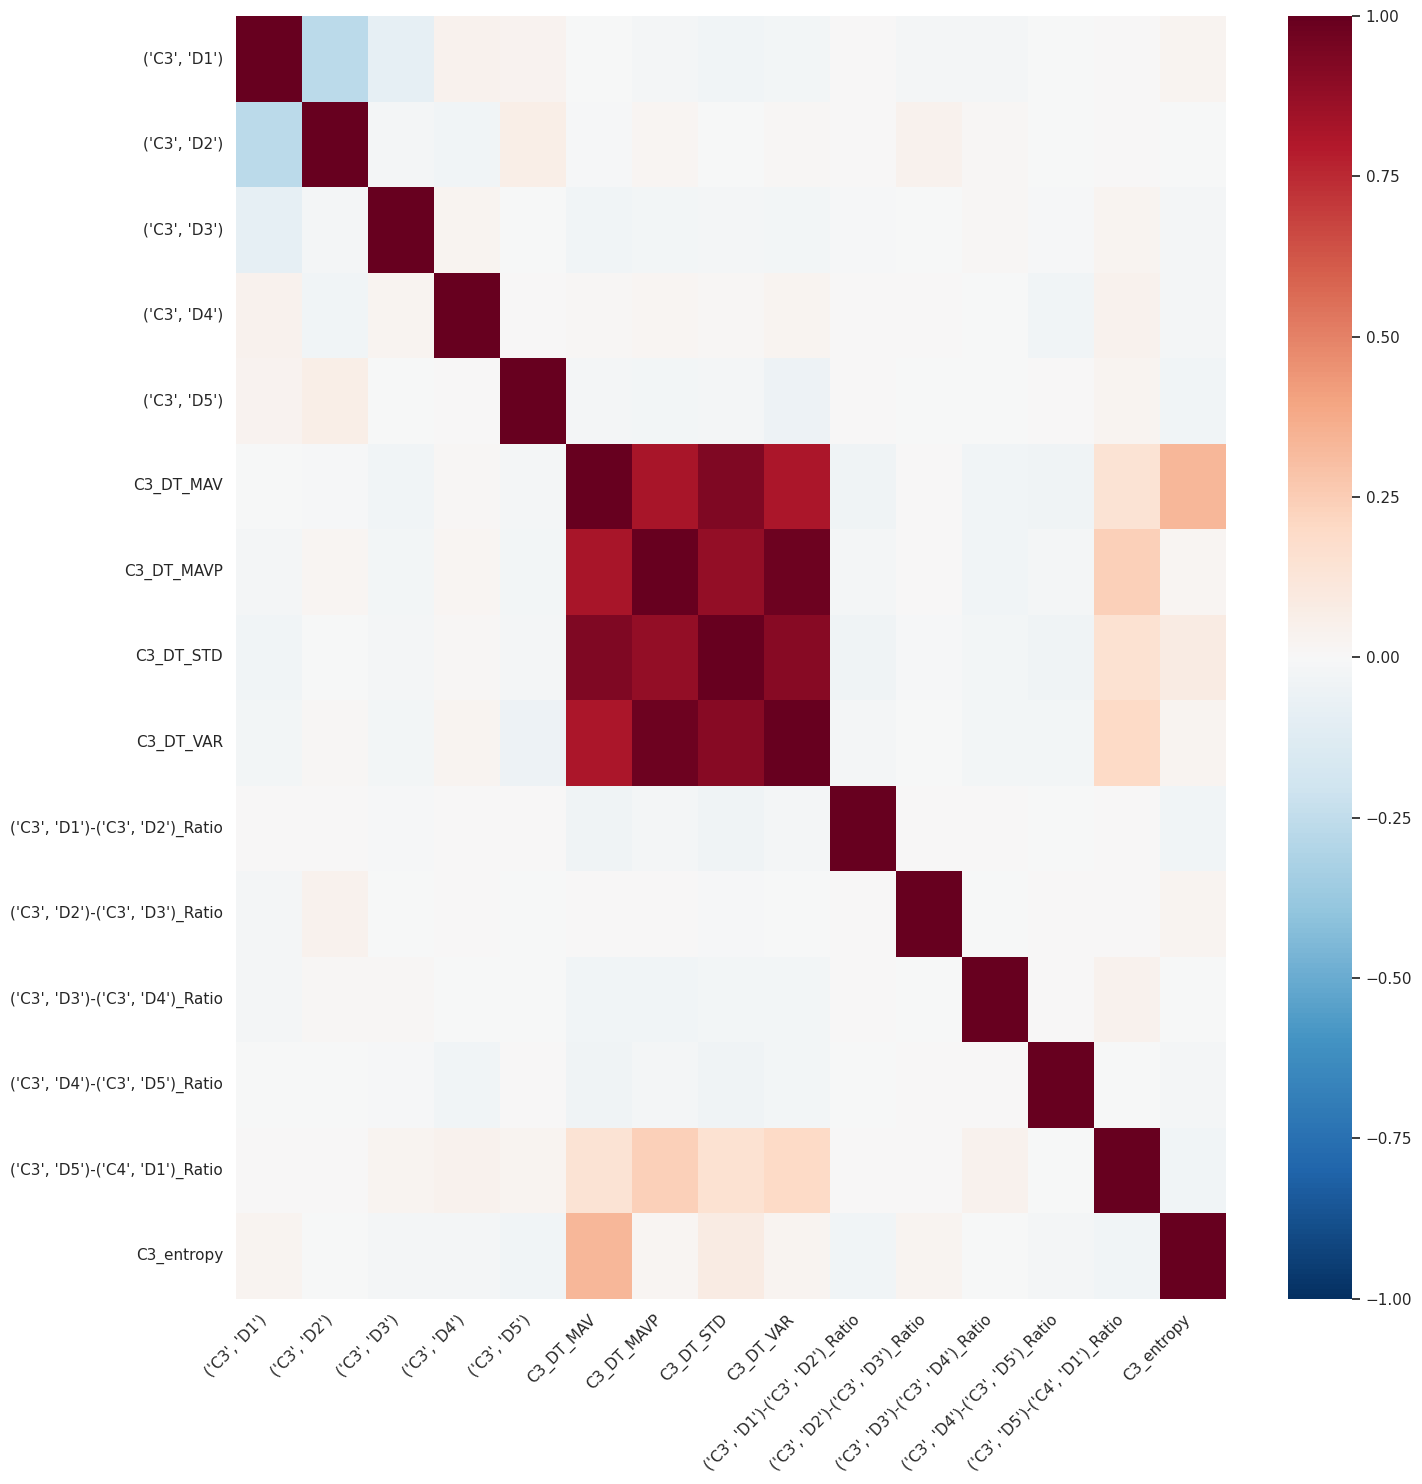

/opt/conda/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/opt/conda/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


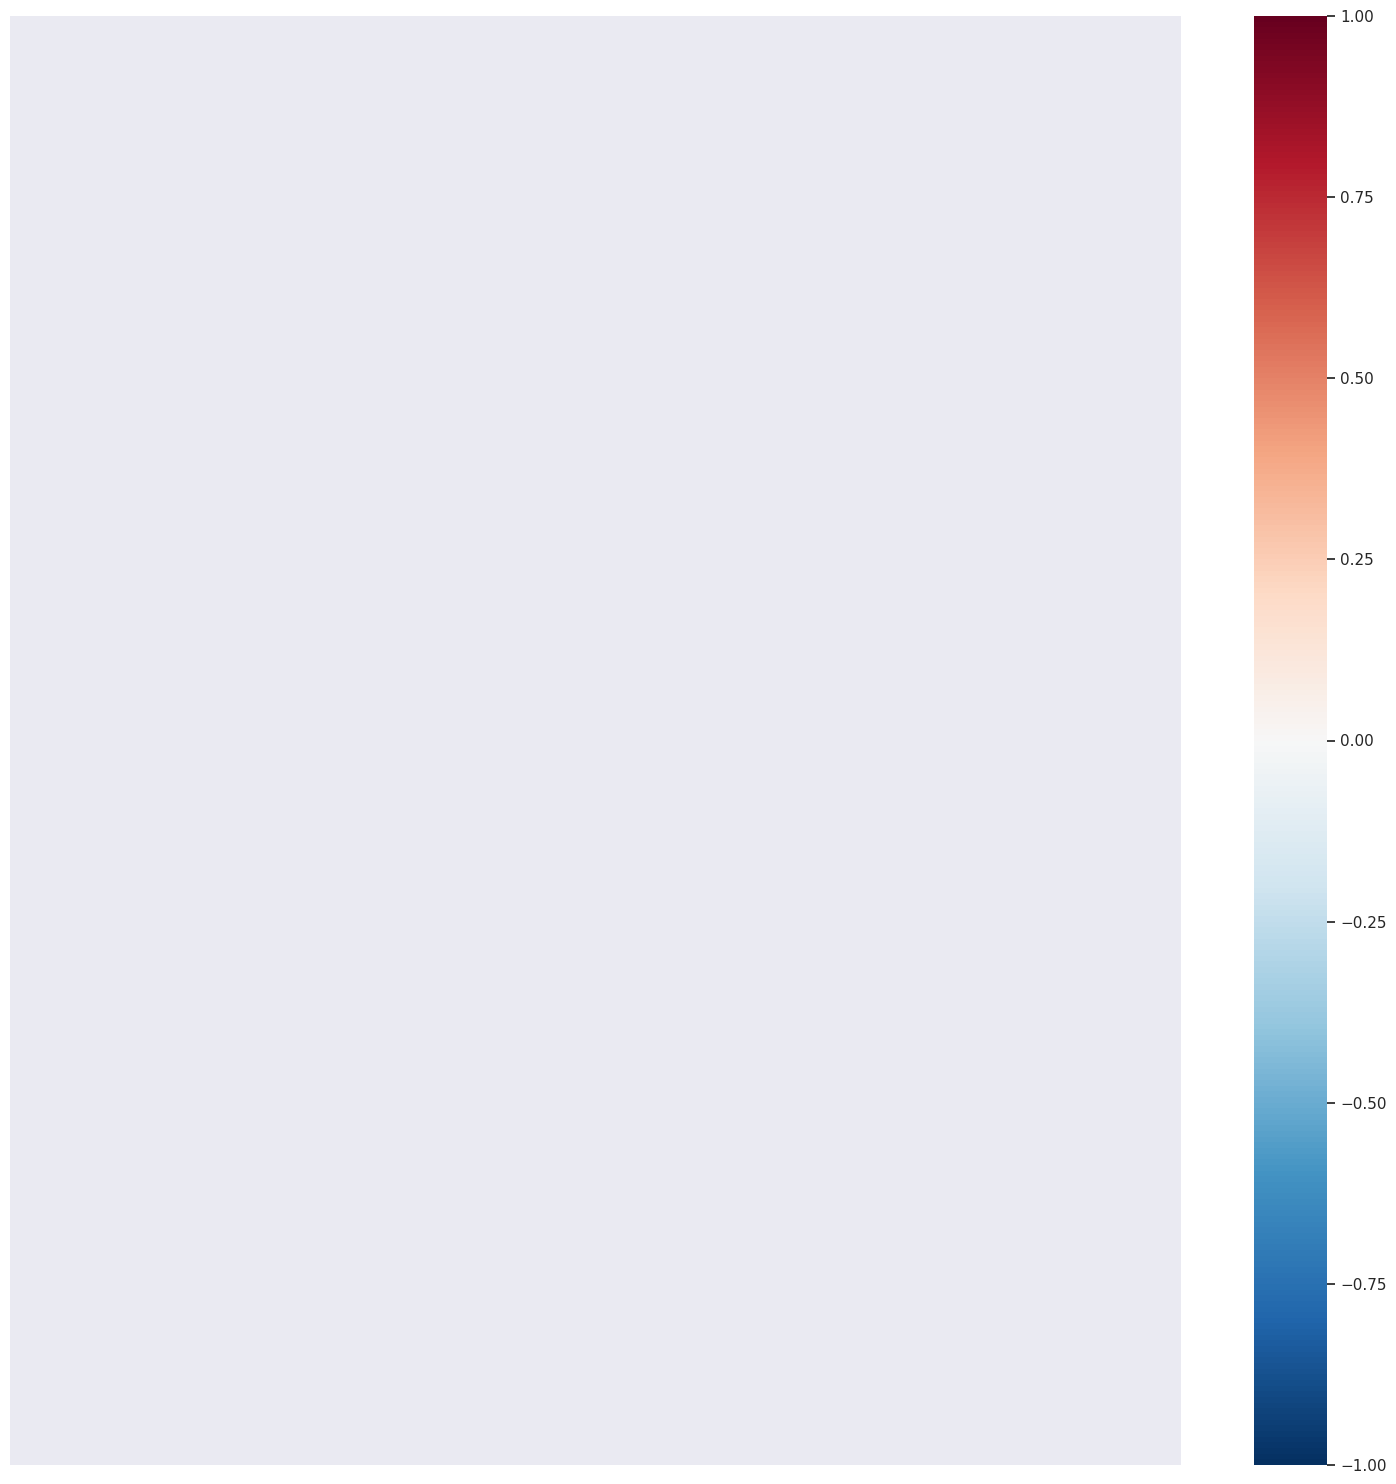

In [32]:
import seaborn as sns; sns.set(color_codes=True)
from IPython.display import Image
import numpy as np

# just first channel
first_channel = dwt_with_statistics.filter(regex='C3')
# just the first feature
first_feature = dwt_with_statistics.filter(regex='C3, D1')

for i, data in enumerate([first_channel, first_feature]):

    correlations = data.corr()
    # plot correlation matrix
    plt.figure(figsize=(15,15))
    sns.heatmap(correlations, 
                vmin=-1, 
                vmax=1,
                xticklabels=correlations.columns.values,
                yticklabels=correlations.columns.values,
                cmap="RdBu_r"
               )
    plt.xticks(rotation=45,ha='right')
    plt.tight_layout()
    
    plt.show()

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

dwt_with_statistics.columns = dwt_with_statistics.columns.astype(str)


print(dwt_with_statistics.isnull().sum())
print(np.isinf(dwt_with_statistics).sum())

median = dwt_with_statistics.median()
dwt_with_statistics = dwt_with_statistics.mask(dwt_with_statistics.sub(median).div(median).abs().gt(3))

# Replace NaN values with median
dwt_with_statistics.fillna(median, inplace=True)

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(dwt_with_statistics)

('C3', 'D1')    0
('C3', 'D2')    0
('C3', 'D3')    0
('C3', 'D4')    0
('C3', 'D5')    0
               ..
Pz_entropy      0
T3_entropy      0
T4_entropy      0
T5_entropy      0
T6_entropy      0
Length: 299, dtype: int64
('C3', 'D1')    0
('C3', 'D2')    0
('C3', 'D3')    0
('C3', 'D4')    0
('C3', 'D5')    0
               ..
Pz_entropy      0
T3_entropy      0
T4_entropy      0
T5_entropy      0
T6_entropy      0
Length: 299, dtype: int64


In [46]:
normalized_data

array([[4.59884745e-02, 4.97996441e-01, 4.97665785e-01, ...,
        7.59653839e-01, 6.25051384e-01, 6.65704267e-01],
       [5.04013010e-01, 4.97996441e-01, 4.97665785e-01, ...,
        8.19484864e-01, 7.11416369e-01, 7.79903166e-01],
       [5.04013010e-01, 4.97996441e-01, 4.97665785e-01, ...,
        8.65350465e-01, 8.71716809e-01, 7.17684999e-01],
       ...,
       [7.79477520e-01, 7.95557157e-01, 4.97665785e-01, ...,
        4.19781541e-01, 6.01202396e-02, 4.82885456e-01],
       [5.04013010e-01, 4.97996441e-01, 4.97665785e-01, ...,
        4.54821499e-01, 6.76472975e-01, 4.60052837e-01],
       [1.03217268e-05, 4.97996441e-01, 4.97665785e-01, ...,
        4.60099790e-01, 3.01311796e-01, 4.81361495e-01]])

In [ ]:
from sklearn.feature_selection import mutual_info_classif

plt.figure(figsize=(15,10))

mi = mutual_info_classif(X_train, y_train)
mi_series = pd.Series(mi, index=feat_labels).sort_values(ascending = False)

# lets plot the top 30
PLOT_NUM = 30
mi_series[:PLOT_NUM].plot.bar(legend = False, figsize=(15,10))
plt.title('Mutual information (' + str(PLOT_NUM) + ')')

plt.xticks(rotation=45,ha='right')
plt.tight_layout()
#plt.savefig('mutual_information.png', dpi=300)
plt.show()

## CNN Model Implementation

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Model

def build_cnn_rnn_model(input_shape=(310, 19), num_classes=2):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # CNN Module (DenseNet-BC architecture)
    x = inputs
    growth_rate = 32
    for i in range(7):
        x = dense_block(x, growth_rate, layers=4)
        if i != 6:
            x = transition_block(x)
    
    # RNN Module (Bidirectional LSTM)
    x = Bidirectional(LSTM(units=8, return_sequences=True))(x)
    
    # Fully Connected Layer
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    
    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

def dense_block(x, growth_rate, layers=4):
    for _ in range(layers):
        x = conv_block(x, growth_rate)
    return x

def conv_block(x, growth_rate):
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv1D(filters=4*growth_rate, kernel_size=1, padding='same')(x1)
    
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv1D(filters=growth_rate, kernel_size=3, padding='same')(x1)
    
    x = tf.keras.layers.concatenate([x, x1], axis=-1)
    return x

def transition_block(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters=int(x.shape[-1])//2, kernel_size=1, padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    return x

# Build the model
model = build_cnn_rnn_model()
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 310, 19)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 310, 19)   │         76 │ input_layer_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_62       │ (None, 310, 19)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 310, 128)  │      2,560 │ activation_62[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 310, 128)  │        512 │ conv1d_62[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_63       │ (None, 310, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 310, 32)   │     12,320 │ activation_63[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_28      │ (None, 310, 51)   │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ conv1d_63[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 310, 51)   │        204 │ concatenate_28[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_64       │ (None, 310, 51)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 310, 128)  │      6,656 │ activation_64[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 310, 128)  │        512 │ conv1d_64[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_65       │ (None, 310, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 310, 32)   │     12,320 │ activation_65[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_29      │ (None, 310, 83)   │          0 │ concatenate_28[0… │
│ (Concatenate)       │                   │            │ conv1d_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 310, 83)   │        332 │ concatenate_29[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 310, 83)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 310, 128)  │     10,752 │ activation_66[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,070,317 (4.08 MB)

 Trainable params: 1,052,407 (4.01 MB)

 Non-trainable params: 17,910 (69.96 KB)

We define functions to create the CNN and RNN modules separately.

The build_cnn_rnn_model function integrates both modules into a single model.

The **CNN** module consists of **7 dense blocks, each containing 4 convolutional layers** with a **growth rate of 32.**

Between dense blocks, transition blocks are used to reduce the number of feature maps and downsample the input.

After the CNN module, **a bidirectional LSTM layer** is added to capture long-term dependencies.

Finally, a fully connected layer and an output layer are added for classification.

We then build the model and print its summary to examine the architecture.

In [ ]:
model.compile(optimizer='adam', loss='kullback_leibler_divergence', metrics=['accuracy'])

# 3. Train the model
# Example:
# Train the model using the SWT dataset
history = model.fit(normalized_data, y_train, epochs=10, batch_size=32, validation_split=0.2)

# 4. Evaluate the model
# Example:
# Evaluate the trained model on the test set
test_loss, test_accuracy = model.evaluate(X_test_normalized, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Optional: Visualize training history
# Example:
# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()